In [1]:
# make boxplot with individual data points
import csv
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as ss
from matplotlib import style
from matplotlib.lines import Line2D

#pretty display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 9)


%config InlineBackend.figure_format = 'retina'
# figure out number of indels

In [36]:
# align hpv reads in the bins
df_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/hpv_fastqs.txt.csv', sep='\t')
df_files.head()

with open('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/align_scripts.sh',  'w') as fh:
    writer = csv.writer(fh)
    for index, row in df_files.iterrows():
        line1 = [('/home/rcorbett/aligners/bwa/bwa-0.7.9a/bwa mem Human_papillomavirus_appended_headers.fa {0} {1} >{2}.sam').format(row.hpv_fastq1, row.hpv_fastq2, row.patient)]
        line2 = [('/home/rcorbett/aligners/samtools/samtools-0.1.17/samtools view -S -b {0}.sam -o {0}.bam').format(row.patient)]
        line3 = [('/home/rcorbett/aligners/samtools/samtools-0.1.17/samtools sort {0}.bam {0}.bam.sorted').format(row.patient)]
        line4 = [('/home/rcorbett/aligners/samtools/samtools-0.1.17/samtools index {0}.bam.sorted.bam').format(row.patient)]
        writer.writerow(line1)
        writer.writerow(line2)
        writer.writerow(line3)        
        writer.writerow(line4)

,patient,hpv_strains_detected_in_RNA,RNA_library,hpv_fastq1,hpv_fastq2
0,HTMCP-03-06-02202,APV_9;HPV_16,A57112,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...
1,HTMCP-03-06-02217,APV_9;HPV_16,A57115,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...
2,HTMCP-03-06-02239,APV_9;HPV_16,A57122,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...
3,HTMCP-03-06-02240,APV_9;HPV_16,A57123,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...
4,HTMCP-03-06-02001,HPV_16,A37700,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...


analyze E6 E7 expression

In [37]:
cd /projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression

/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression


In [87]:
bam_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/patient_bams.txt',names=('patient', 'bam'))
bam_files.head()

,patient,bam
0,HTMCP-03-06-02001,/projects/trans_scratch/validations/workspace/...
1,HTMCP-03-06-02002,/projects/trans_scratch/validations/workspace/...
2,HTMCP-03-06-02003,/projects/trans_scratch/validations/workspace/...
3,HTMCP-03-06-02006,/projects/trans_scratch/validations/workspace/...
4,HTMCP-03-06-02007,/projects/trans_scratch/validations/workspace/...


run bedcoverage to get coverage for E6 and E7 genes

In [4]:
from jinja2 import Environment, FileSystemLoader


def populate_sh_template(template_dir, sh_script, patient_status, bam, gene_bed_file):
    jinja2_env = Environment(loader=FileSystemLoader([template_dir]),
                             trim_blocks=True)
    template = jinja2_env.get_template('bedcoverage_template.sh')
    with open(sh_script, 'w') as opf:
        content = template.render(sh_script=sh_script,
                                  patient=patient_status,
                                  bam=bam,
                                  gene_bed_file=gene_bed_file)
        opf.write(content)
#         print('templated {}'.format(sh_script))
    return sh_script

In [ ]:
template_dir = '/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/'
gene_bed_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/E6_E7_genes.txt'
for index, row in bam_files.iterrows():
    patient = row.patient
    sh_script = '.'.join([patient, 'bedcoverage', 'sh'])
    sh_script = '/'.join([template_dir, sh_script])
    bam = row.bam
    populate_sh_template(template_dir, sh_script, patient, bam, gene_bed_file);


# from jinja2 import Environment, FileSystemLoader


# def populate_sh_template(template_dir, sh_script, patient_status, bam, gene_bed_file):
#     jinja2_env = Environment(loader=FileSystemLoader([template_dir]),
#                              trim_blocks=True)
#     template = jinja2_env.get_template('bedcoverage_template.sh')
#     with open(sh_script, 'w') as opf:
#         content = template.render(sh_script=sh_script,
#                                   patient=patient_status,
#                                   bam=bam,
#                                   gene_bed_file=gene_bed_file)
#         opf.write(content)
# #         print('templated {}'.format(sh_script))
#     return sh_script

In [88]:
# process bedcoverage results
# hpv16_e6_len = 559-83
# hpv16_e7_len = 858-562
# hpv18_e6_len = 581-105
# hpv18_e7_len = 907-590
df_joined = pd.DataFrame()
for index, row in bam_files.iterrows():
    patient = row.patient
    bedcov_file = '.'.join([patient, 'gene', 'coverage', 'txt'])
    df_tmp = pd.read_csv(bedcov_file, sep='\t', names=('virus', 'start', 'end', 'gene', 'position', 'coverage'))

    df_cov = pd.DataFrame(df_tmp.groupby('gene').mean()['coverage'])
    df_cov = df_cov.rename(columns={'coverage':patient})
#     print(df_cov)
    if df_joined.empty:
         df_joined = df_cov
    else:
        df_joined = df_joined.join(df_cov, how='outer')
  

In [89]:
df_joined = df_joined.T.reset_index()
df_joined = df_joined.rename(columns={'index':'patient'})
df_joined.head()

gene,patient,hpv16_2_E6,hpv16_2_E7,hpv16_E6,hpv16_E7,hpv18_E6,hpv18_E7
0,HTMCP-03-06-02001,1237.197479,4162.131757,1315.789916,4155.415541,0.0,0.0
1,HTMCP-03-06-02002,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,HTMCP-03-06-02003,500.023109,1519.402027,530.075630,1548.192568,0.0,0.0
3,HTMCP-03-06-02006,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,HTMCP-03-06-02007,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [90]:
# get virus_gene types
viral_genes = df_joined.drop('patient', axis=1).columns.tolist()
viral_genes

['hpv16_2_E6', 'hpv16_2_E7', 'hpv16_E6', 'hpv16_E7', 'hpv18_E6', 'hpv18_E7']

In [91]:
# add in integration information
df_intg = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hist_hpv_hiv_status_review_updated.csv')
df_intg.fillna('no_hpv', inplace=True)
df_intg.head()

,patient,putative_Histology,library_RNA,RNA_integration_status,HIV_status,comments,chastity_passed_reads,hpv_strains_detected_in_RNA,hpv16_integration_status,hpv18_integration_status
0,HTMCP-03-06-02047,Adeno,A37719,integrated,Negative,na,294015438,HPV_18,no_hpv,integrated
1,HTMCP-03-06-02058,Adeno,A37722,integrated,Positive,na,277011256,HPV_18,no_hpv,integrated
2,HTMCP-03-06-02068,Squamous,A37726,integrated,Negative,na,298823168,HPV_18;HPV_59,no_hpv,integrated
3,HTMCP-03-06-02074,Adeno,A37730,integrated,Negative,na,304771058,HPV_18,no_hpv,integrated
4,HTMCP-03-06-02075,Adeno,A37731,integrated,Negative,na,229609806,HPV_18,no_hpv,integrated


In [92]:
df_merged = pd.merge(df_joined, df_intg)
df_merged.head()

gene,patient,hpv16_2_E6,hpv16_2_E7,hpv16_E6,hpv16_E7,hpv18_E6,hpv18_E7,putative_Histology,library_RNA,RNA_integration_status,HIV_status,comments,chastity_passed_reads,hpv_strains_detected_in_RNA,hpv16_integration_status,hpv18_integration_status
0,HTMCP-03-06-02001,1237.197479,4162.131757,1315.789916,4155.415541,0.0,0.0,Squamous,A37700,integrated,Positive,na,307193606,HPV_16,integrated,no_hpv
1,HTMCP-03-06-02002,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Squamous,A37701,integrated,Negative,na,335033800,HPV_52,no_hpv,no_hpv
2,HTMCP-03-06-02003,500.023109,1519.402027,530.075630,1548.192568,0.0,0.0,Squamous,A37702,integrated,Positive,na,307742504,HPV_16,integrated,no_hpv
3,HTMCP-03-06-02006,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Squamous,A37704,integrated,Negative,reviewed_hpv18_false_positive,311167934,HPV_45,no_hpv,no_hpv
4,HTMCP-03-06-02007,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Adeno,A37705,no_hpv,Negative,na,357608334,no_hpv,no_hpv,no_hpv


In [93]:
intg_statuses = ['hpv16_integration_status', 'hpv18_integration_status']

np.random.seed(0)
# transform coverage to RPM
for gene in viral_genes:
#     print(gene)
    RPM = '_'.join(['logRPM', gene])
#     df_merged[RPM] = np.log2((df_merged[gene]+1)*1000000/df_merged.chastity_passed_reads)
    df_merged[RPM] = (df_merged[gene])*1000000000/df_merged.chastity_passed_reads

In [94]:
df_merged.head()

gene,patient,hpv16_2_E6,hpv16_2_E7,hpv16_E6,hpv16_E7,hpv18_E6,hpv18_E7,putative_Histology,library_RNA,RNA_integration_status,...,chastity_passed_reads,hpv_strains_detected_in_RNA,hpv16_integration_status,hpv18_integration_status,logRPM_hpv16_2_E6,logRPM_hpv16_2_E7,logRPM_hpv16_E6,logRPM_hpv16_E7,logRPM_hpv18_E6,logRPM_hpv18_E7
0,HTMCP-03-06-02001,1237.197479,4162.131757,1315.789916,4155.415541,0.0,0.0,Squamous,A37700,integrated,...,307193606,HPV_16,integrated,no_hpv,4027.419370,13548.887983,4283.259450,13527.024845,0.0,0.0
1,HTMCP-03-06-02002,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Squamous,A37701,integrated,...,335033800,HPV_52,no_hpv,no_hpv,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,HTMCP-03-06-02003,500.023109,1519.402027,530.075630,1548.192568,0.0,0.0,Squamous,A37702,integrated,...,307742504,HPV_16,integrated,no_hpv,1624.810037,4937.251135,1722.464799,5030.805129,0.0,0.0
3,HTMCP-03-06-02006,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Squamous,A37704,integrated,...,311167934,HPV_45,no_hpv,no_hpv,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,HTMCP-03-06-02007,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Adeno,A37705,no_hpv,...,357608334,no_hpv,no_hpv,no_hpv,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [57]:
df_merged[df_merged.patient=='HTMCP-03-06-02012']

gene,patient,hpv16_2_E6,hpv16_2_E7,hpv16_E6,hpv16_E7,hpv18_E6,hpv18_E7,putative_Histology,library_RNA,RNA_integration_status,...,chastity_passed_reads,hpv_strains_detected_in_RNA,hpv16_integration_status,hpv18_integration_status,logRPM_hpv16_2_E6,logRPM_hpv16_2_E7,logRPM_hpv16_E6,logRPM_hpv16_E7,logRPM_hpv18_E6,logRPM_hpv18_E7
6,HTMCP-03-06-02012,11.298319,35.837838,10.964286,41.422297,0.0,0.236593,Squamous,A37707,integrated,...,343768978,HPV_16;HPV_18;HPV_34;HPV_58;HPV_73,integrated,no_hpv,-4.804906,-3.222179,-4.844633,-3.018545,-8.425296,-8.118925


In [58]:
df_merged.to_csv('hpv16_18_E6_7_expression.txt', index=False, sep='\t')

In [18]:
df_merged.HIV_status.unique()

array(['Positive', 'Negative'], dtype=object)

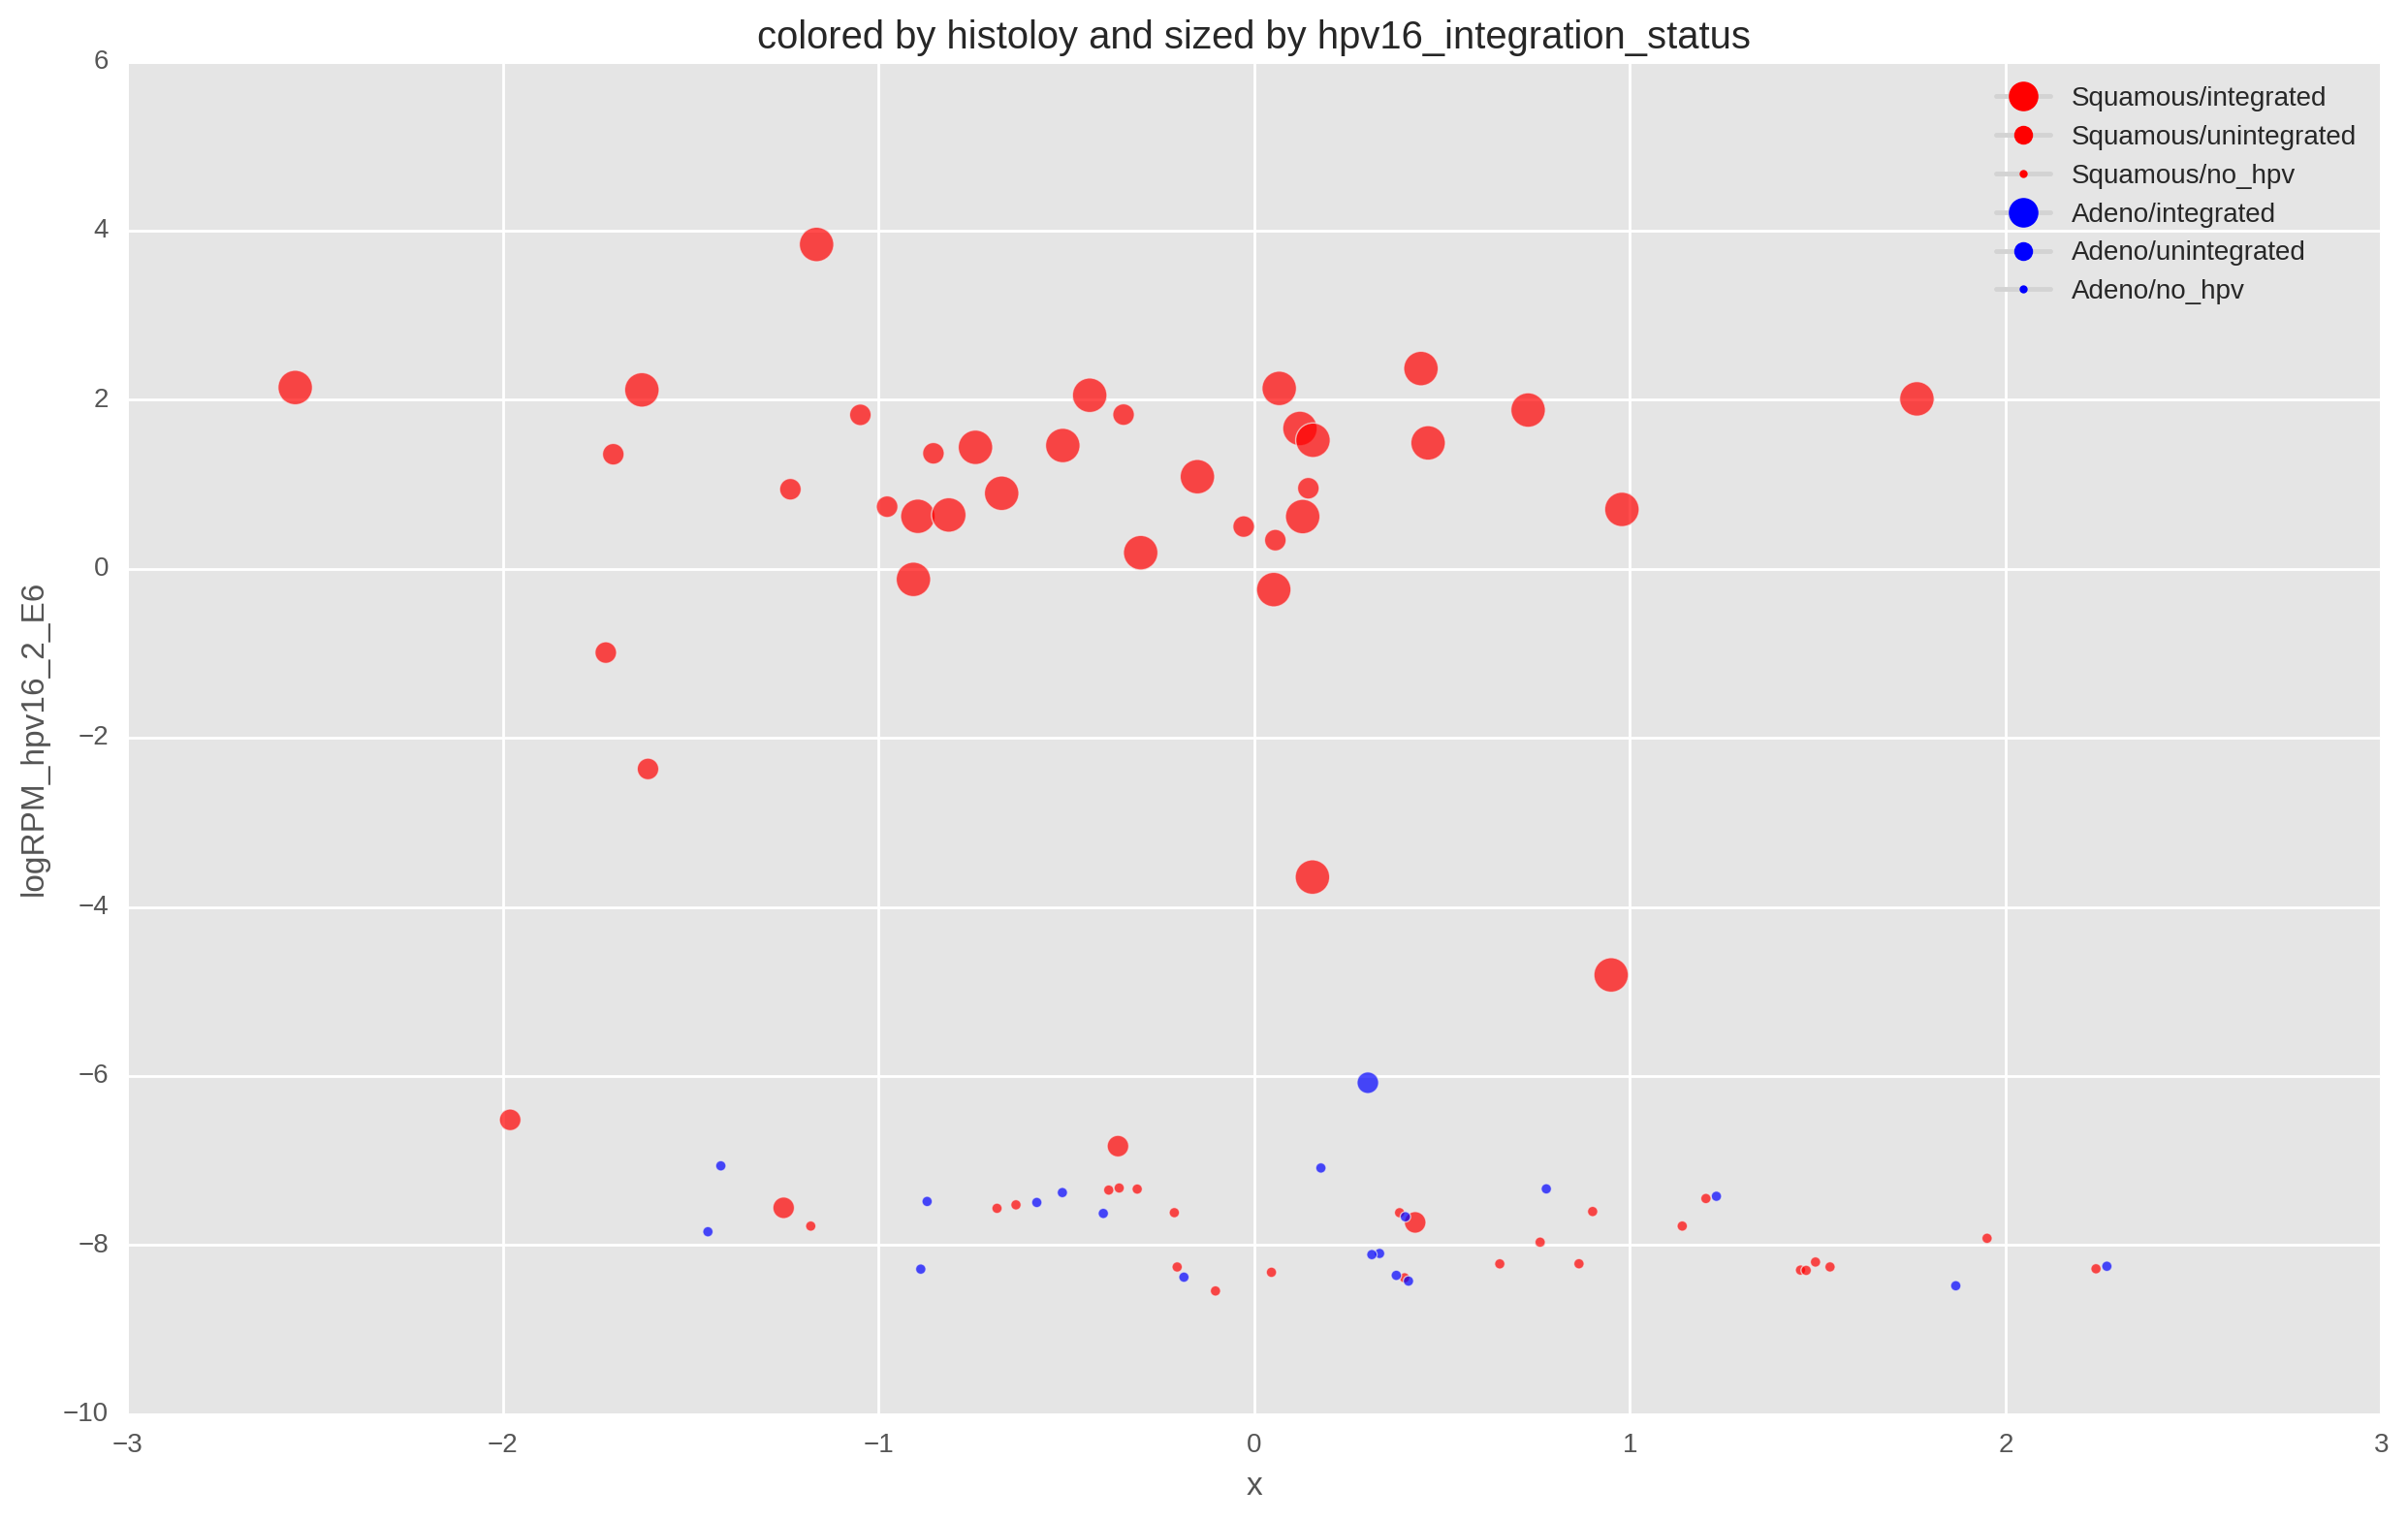

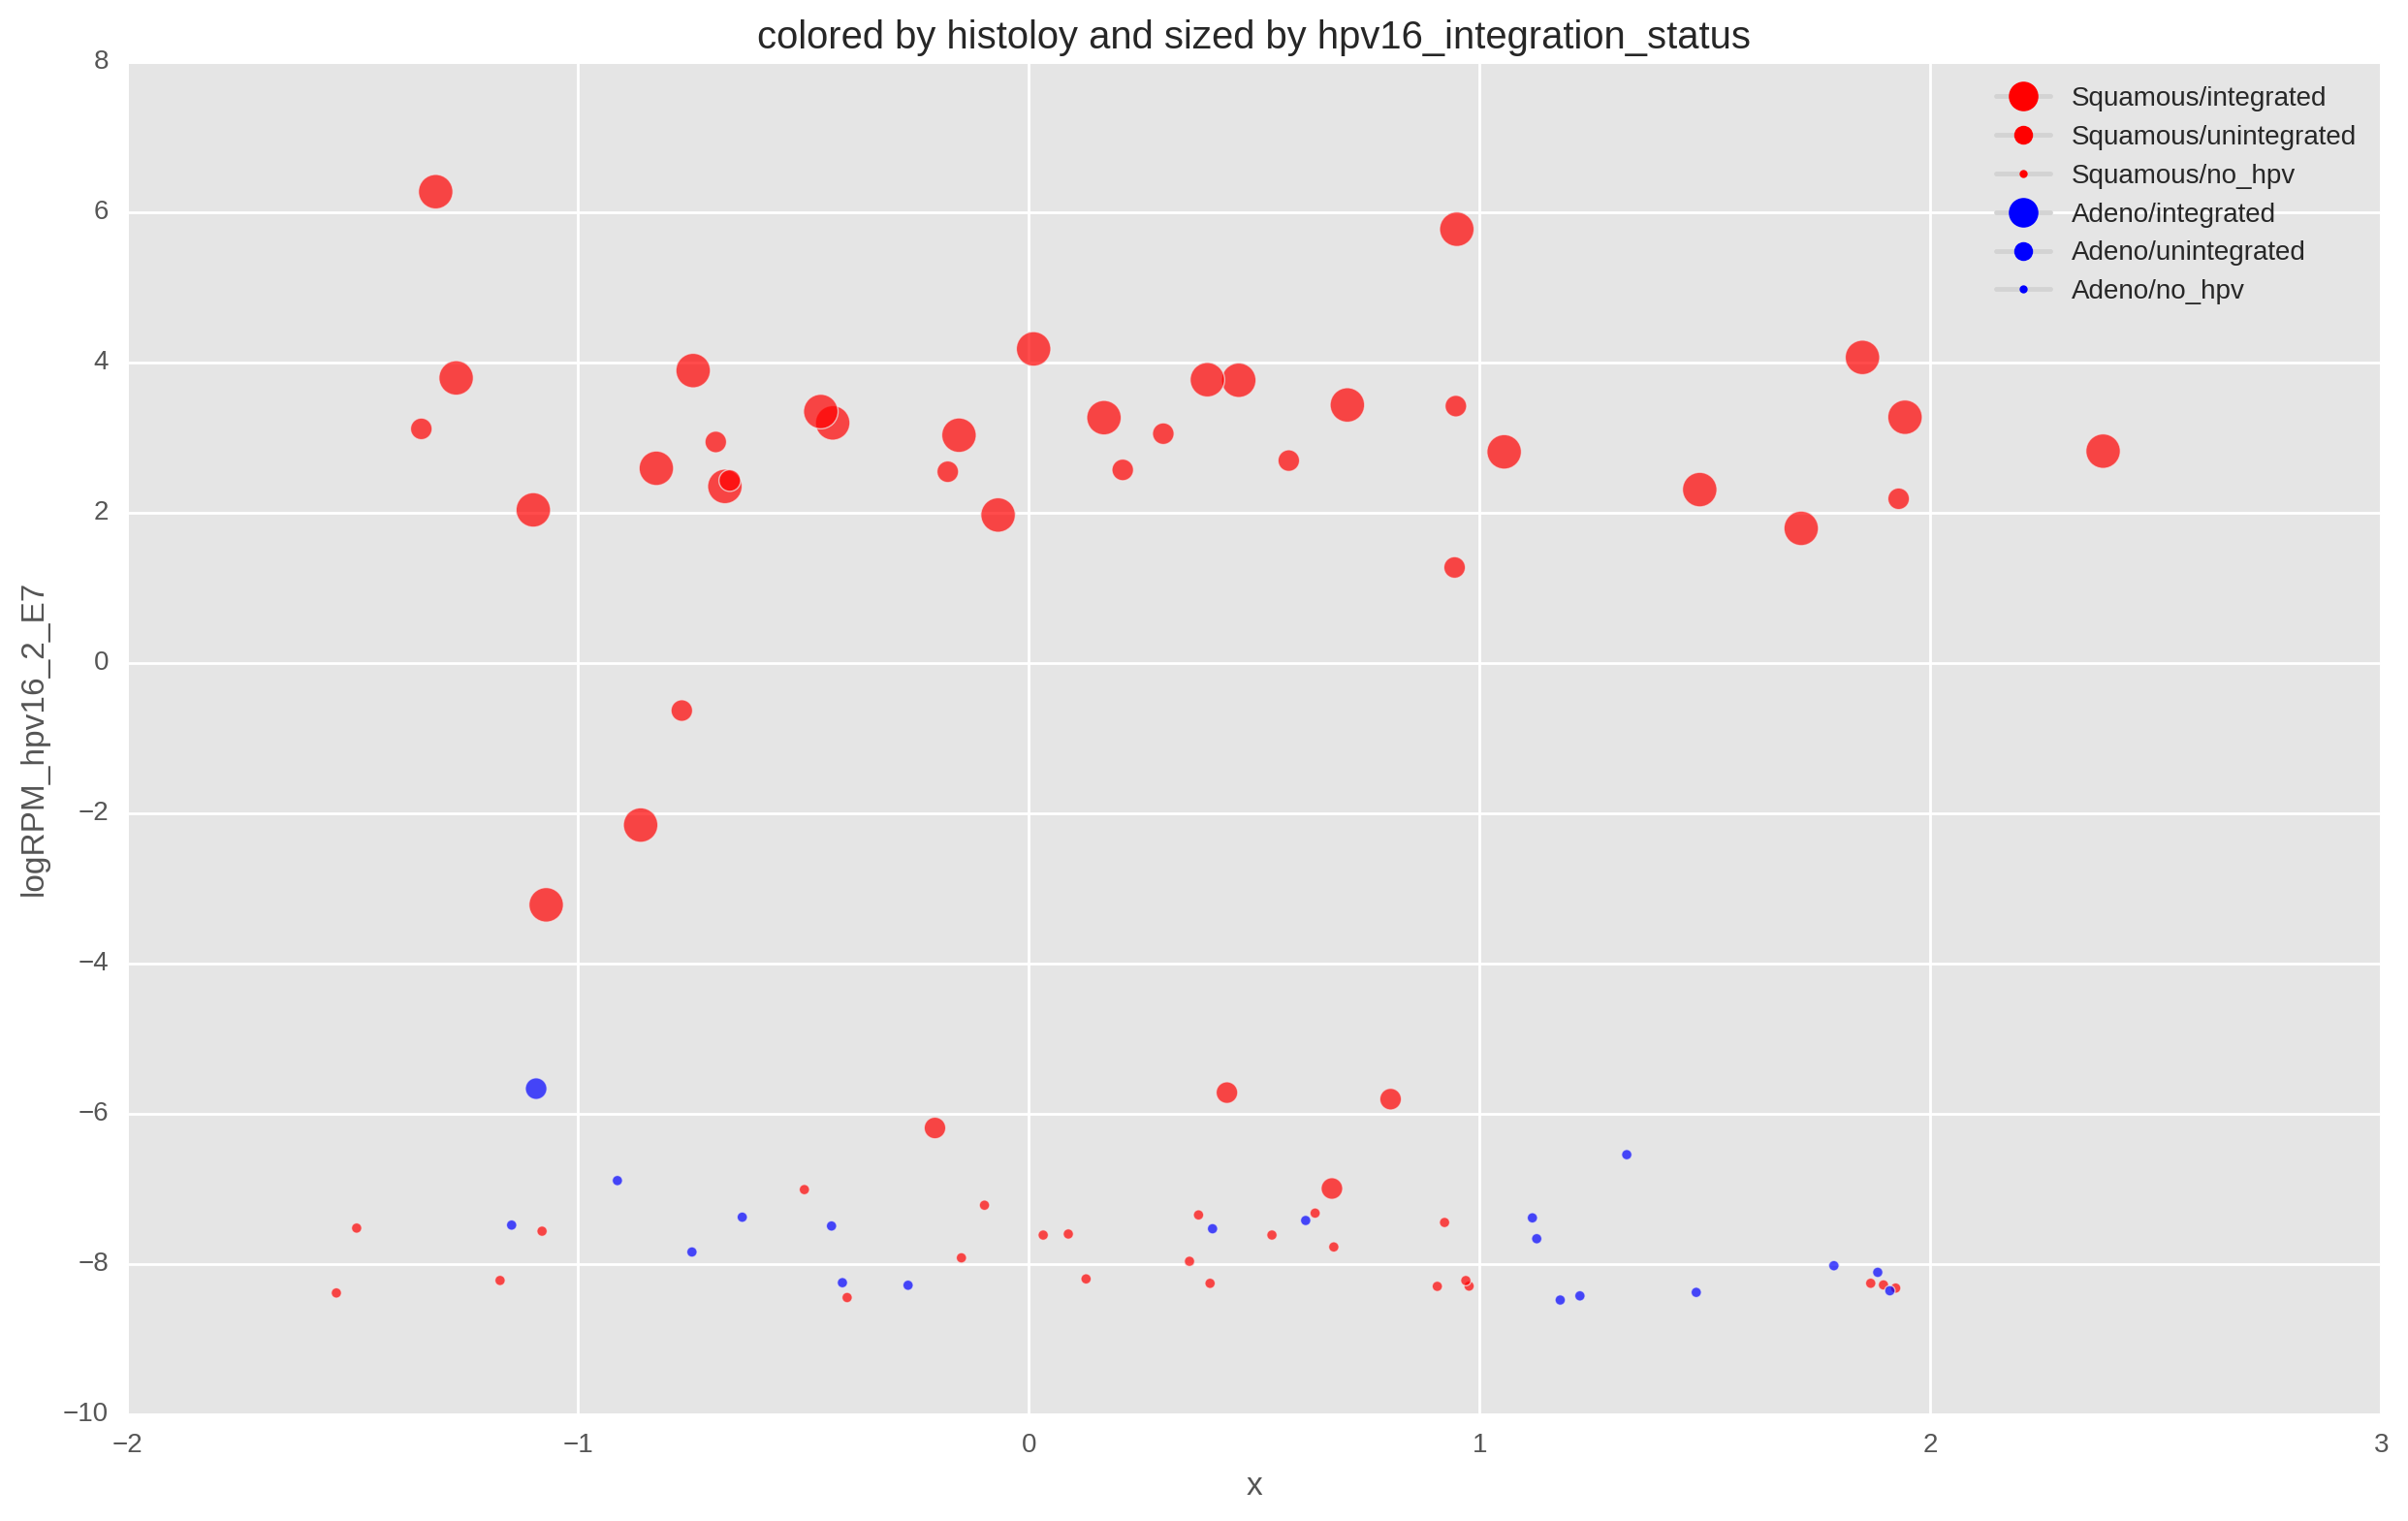

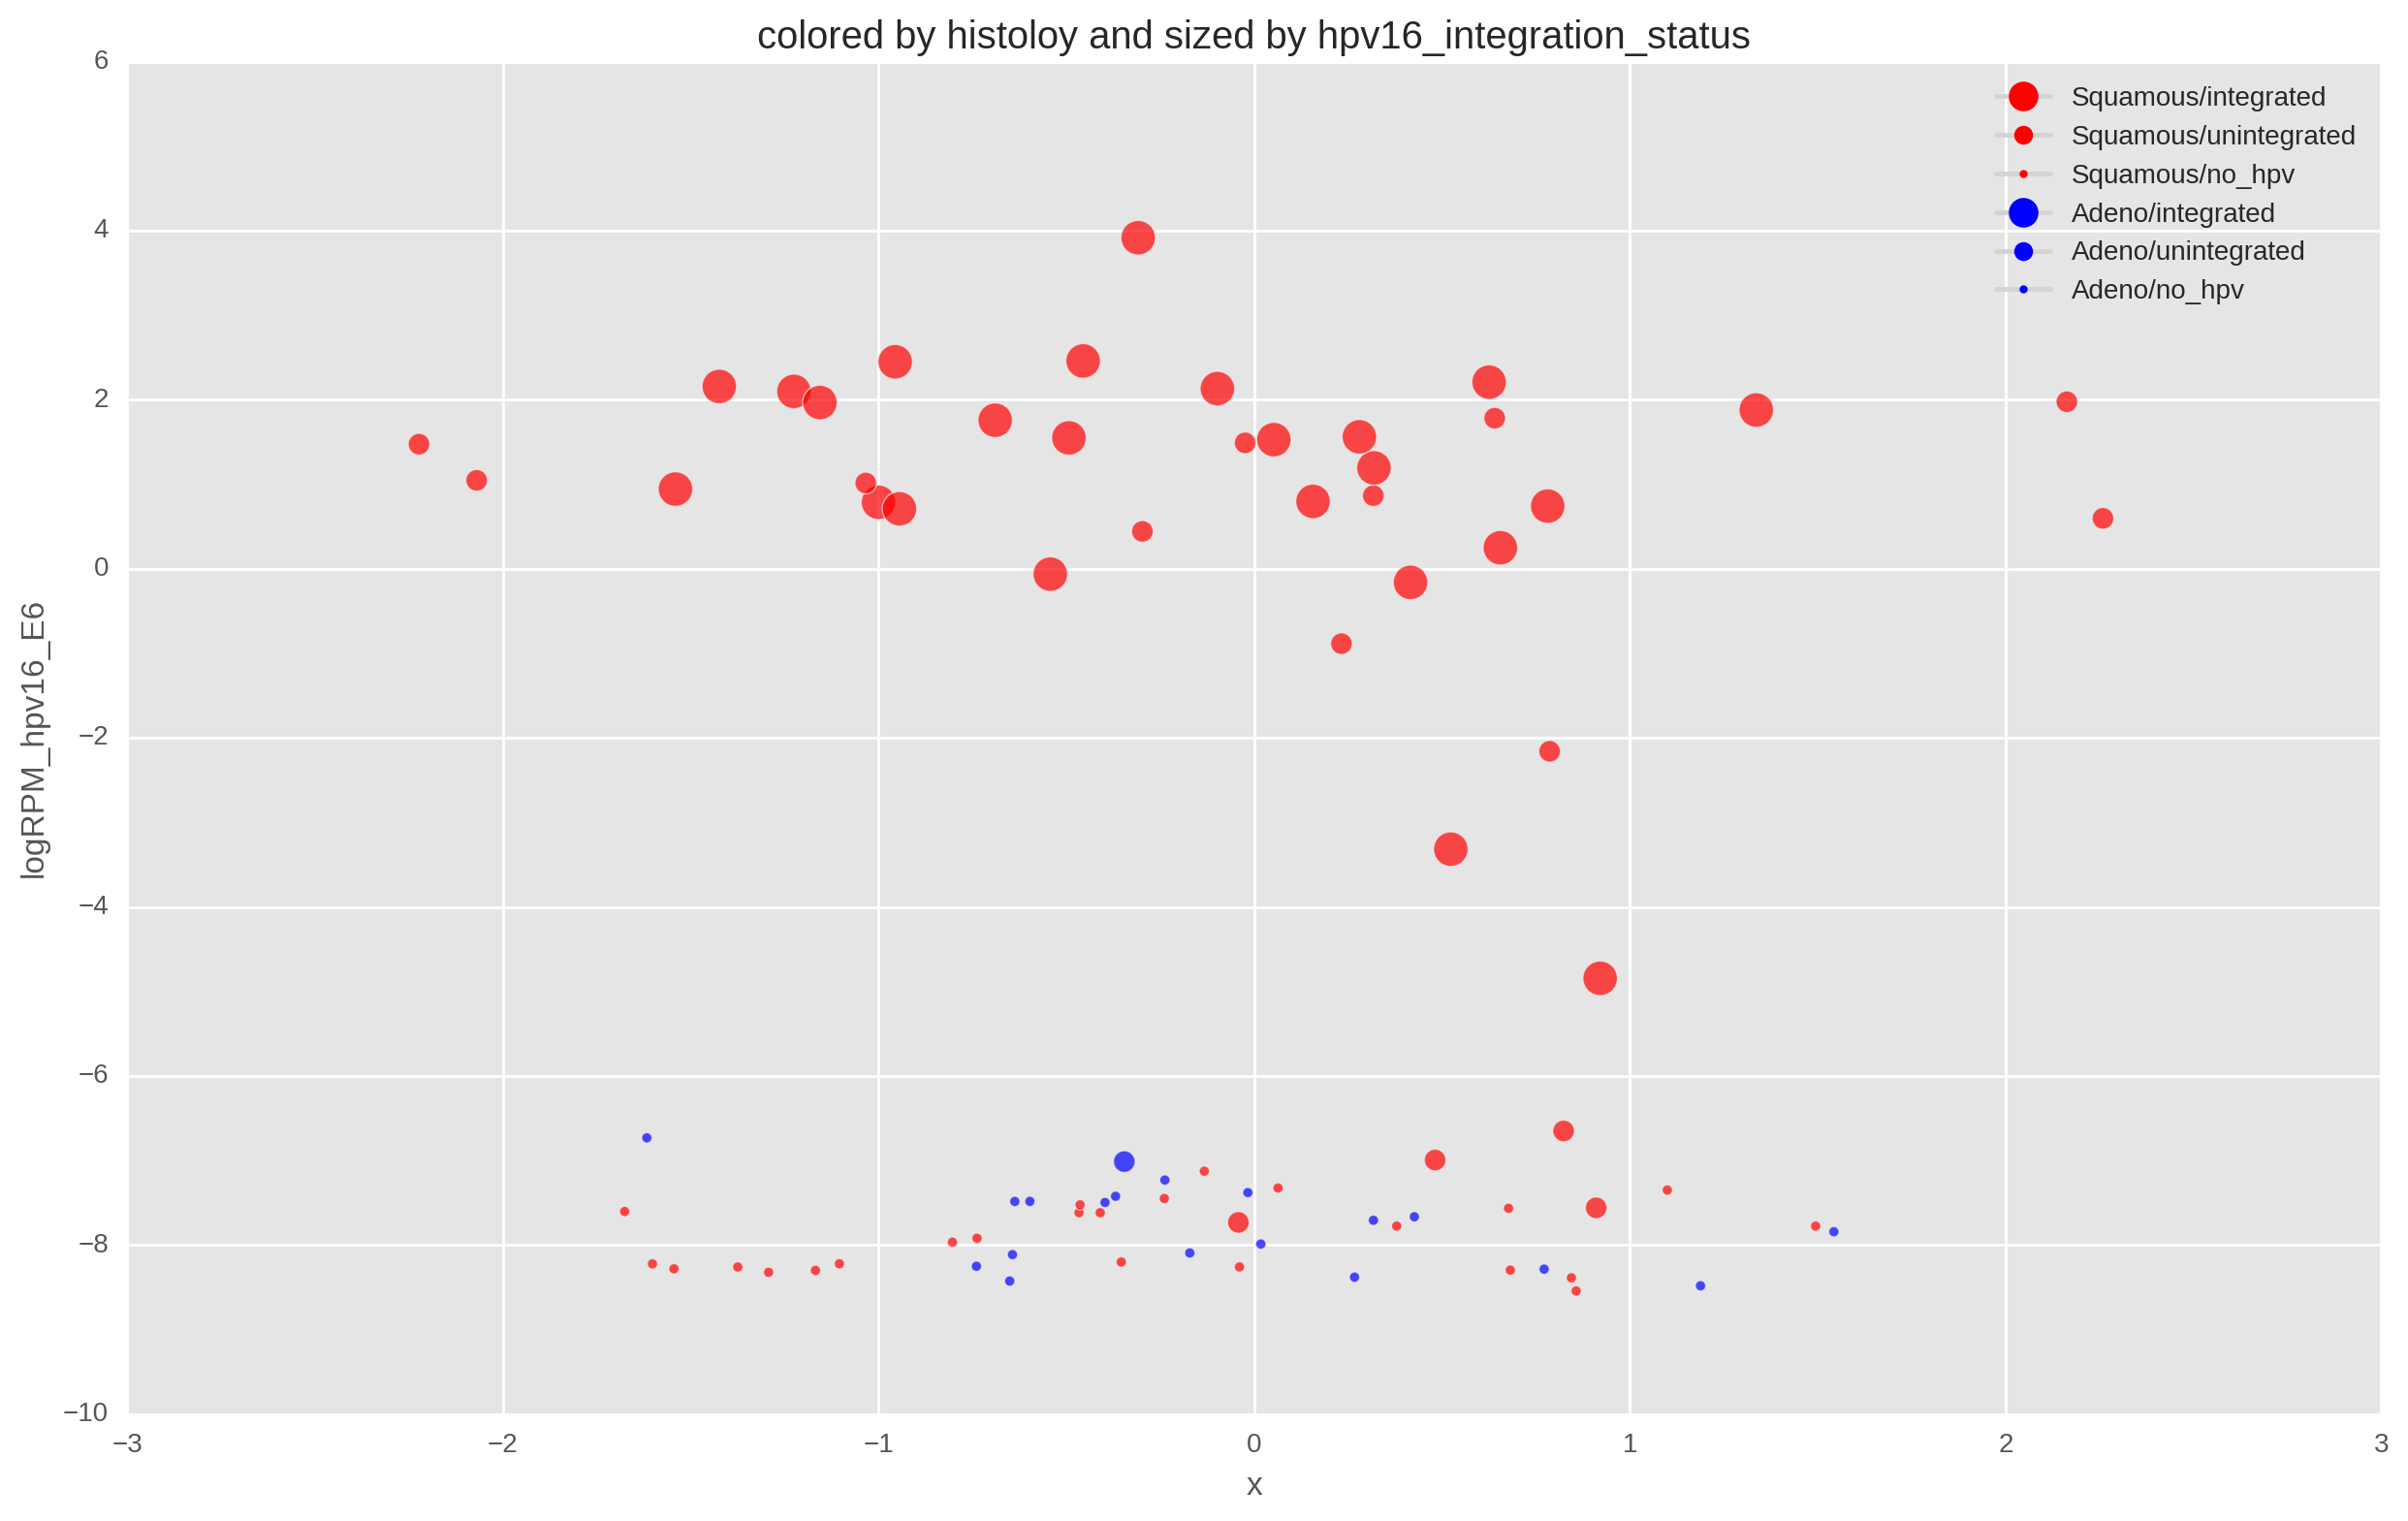

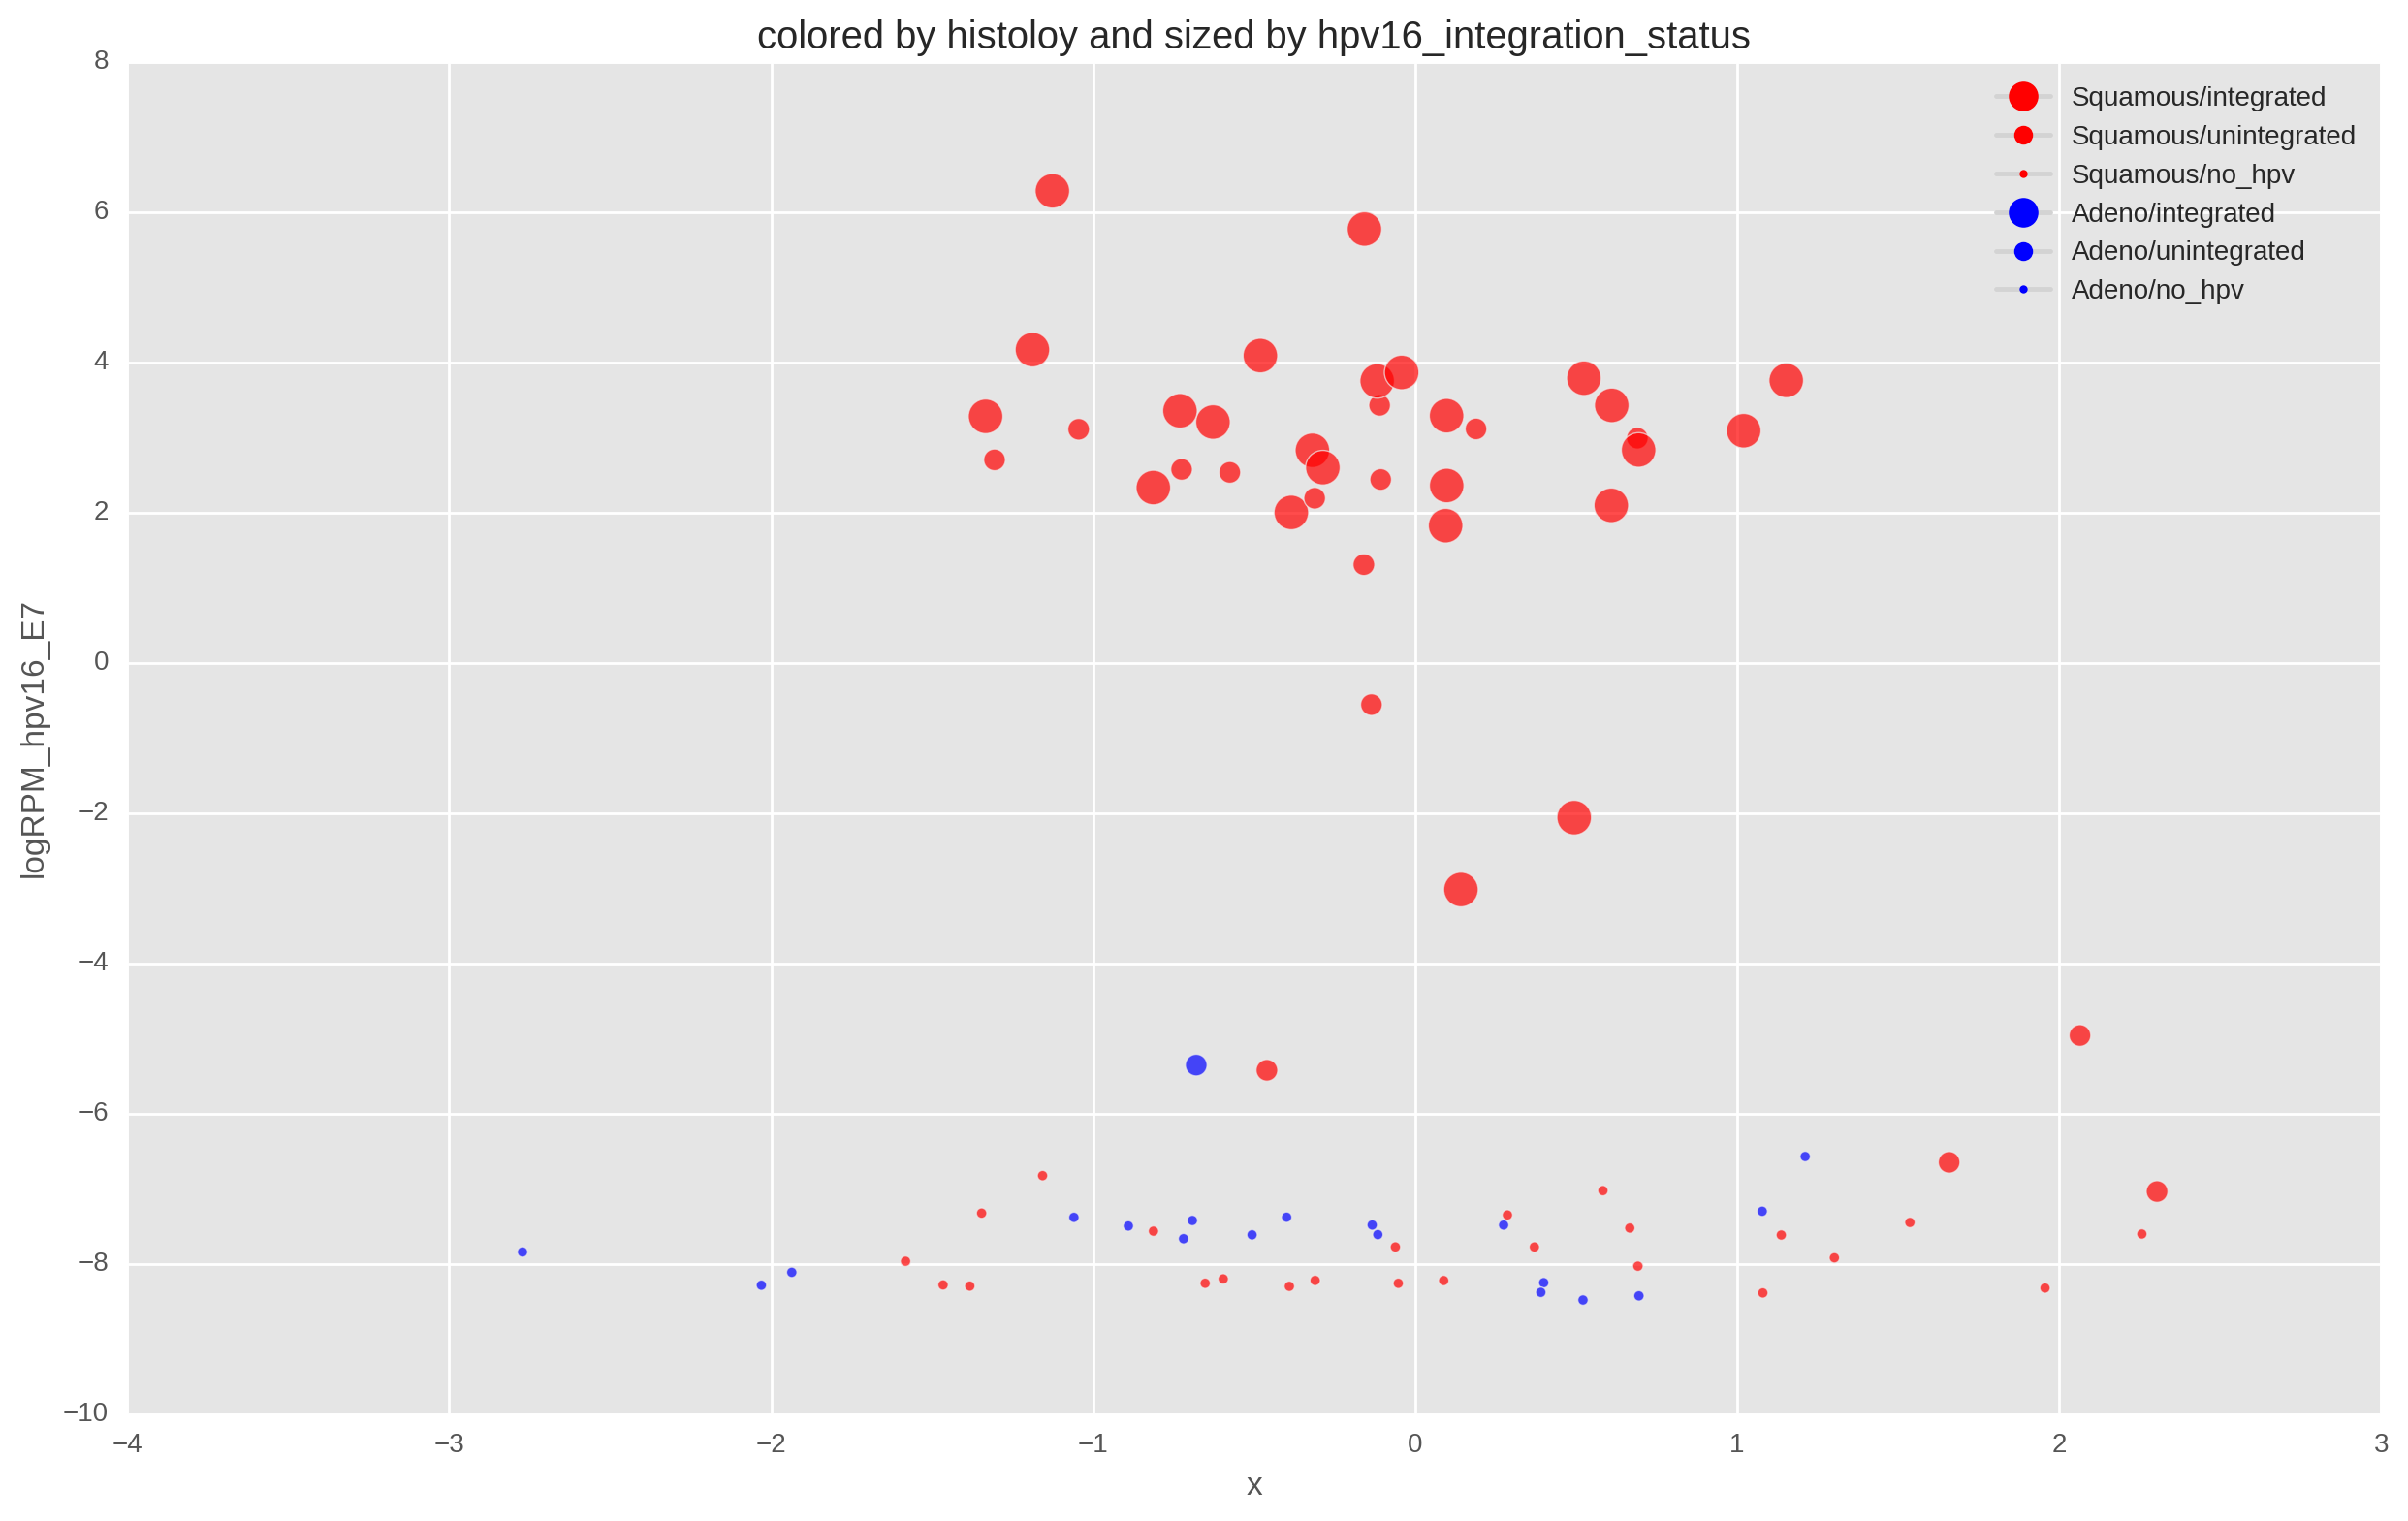

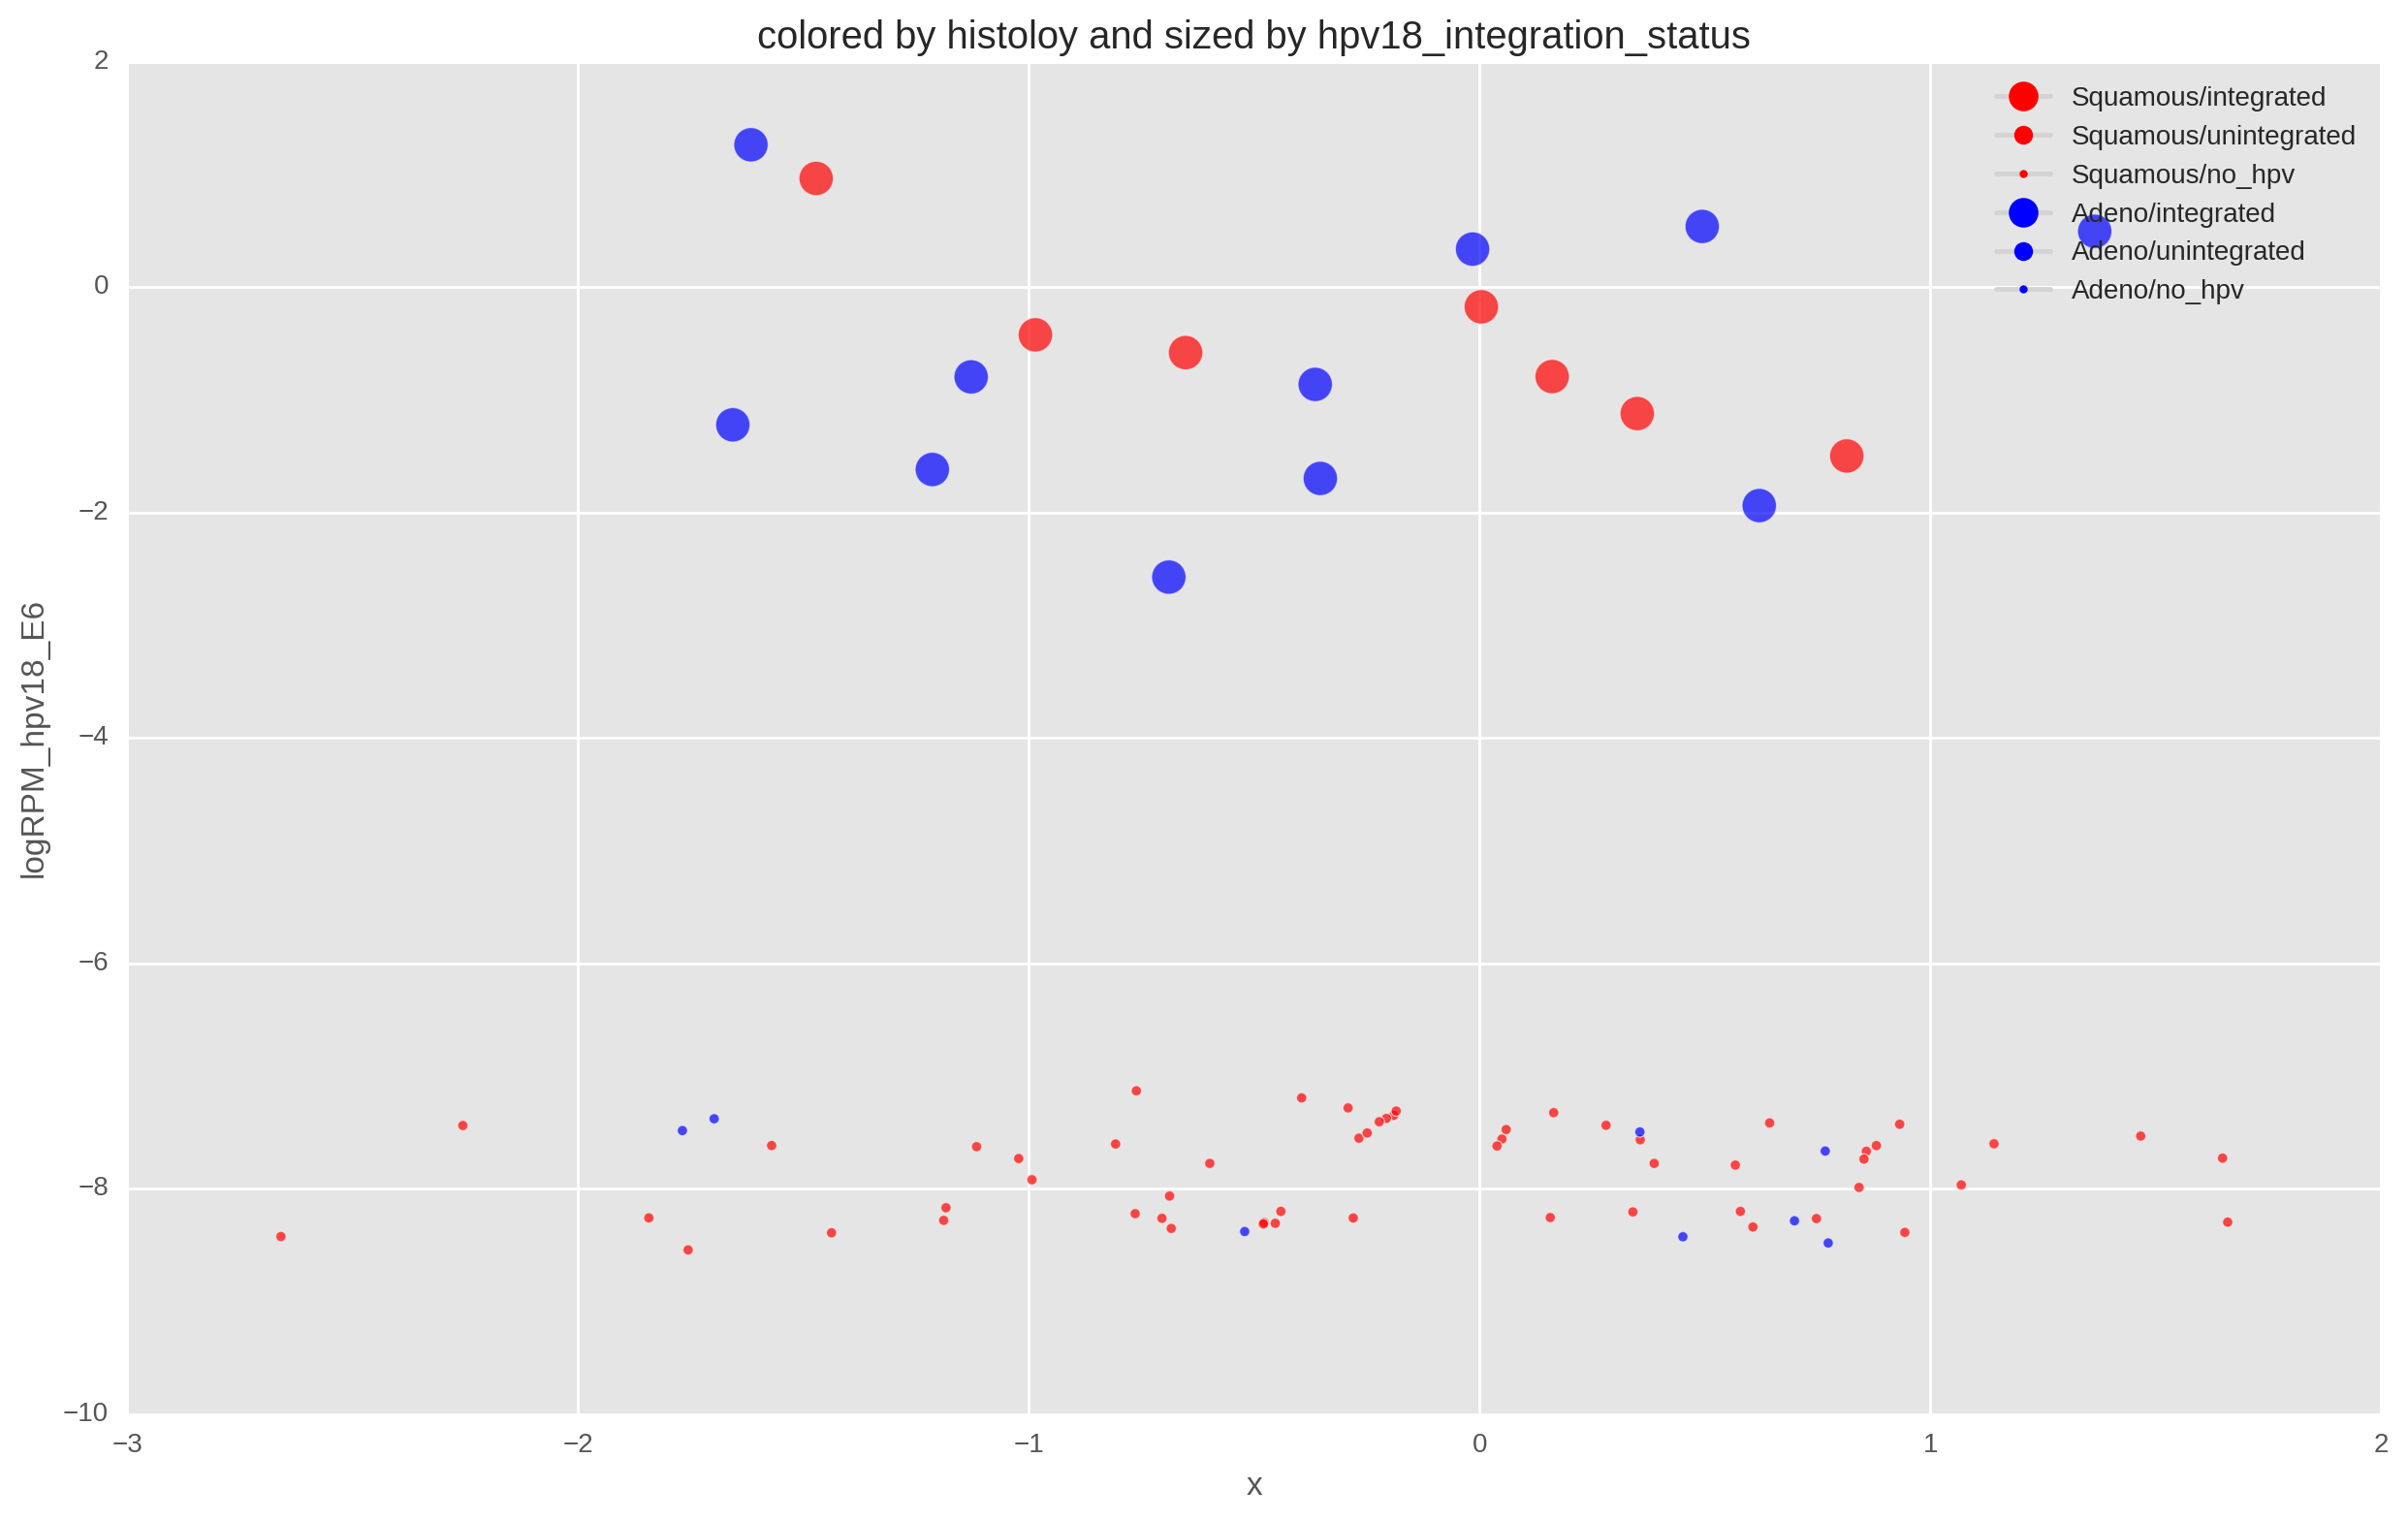

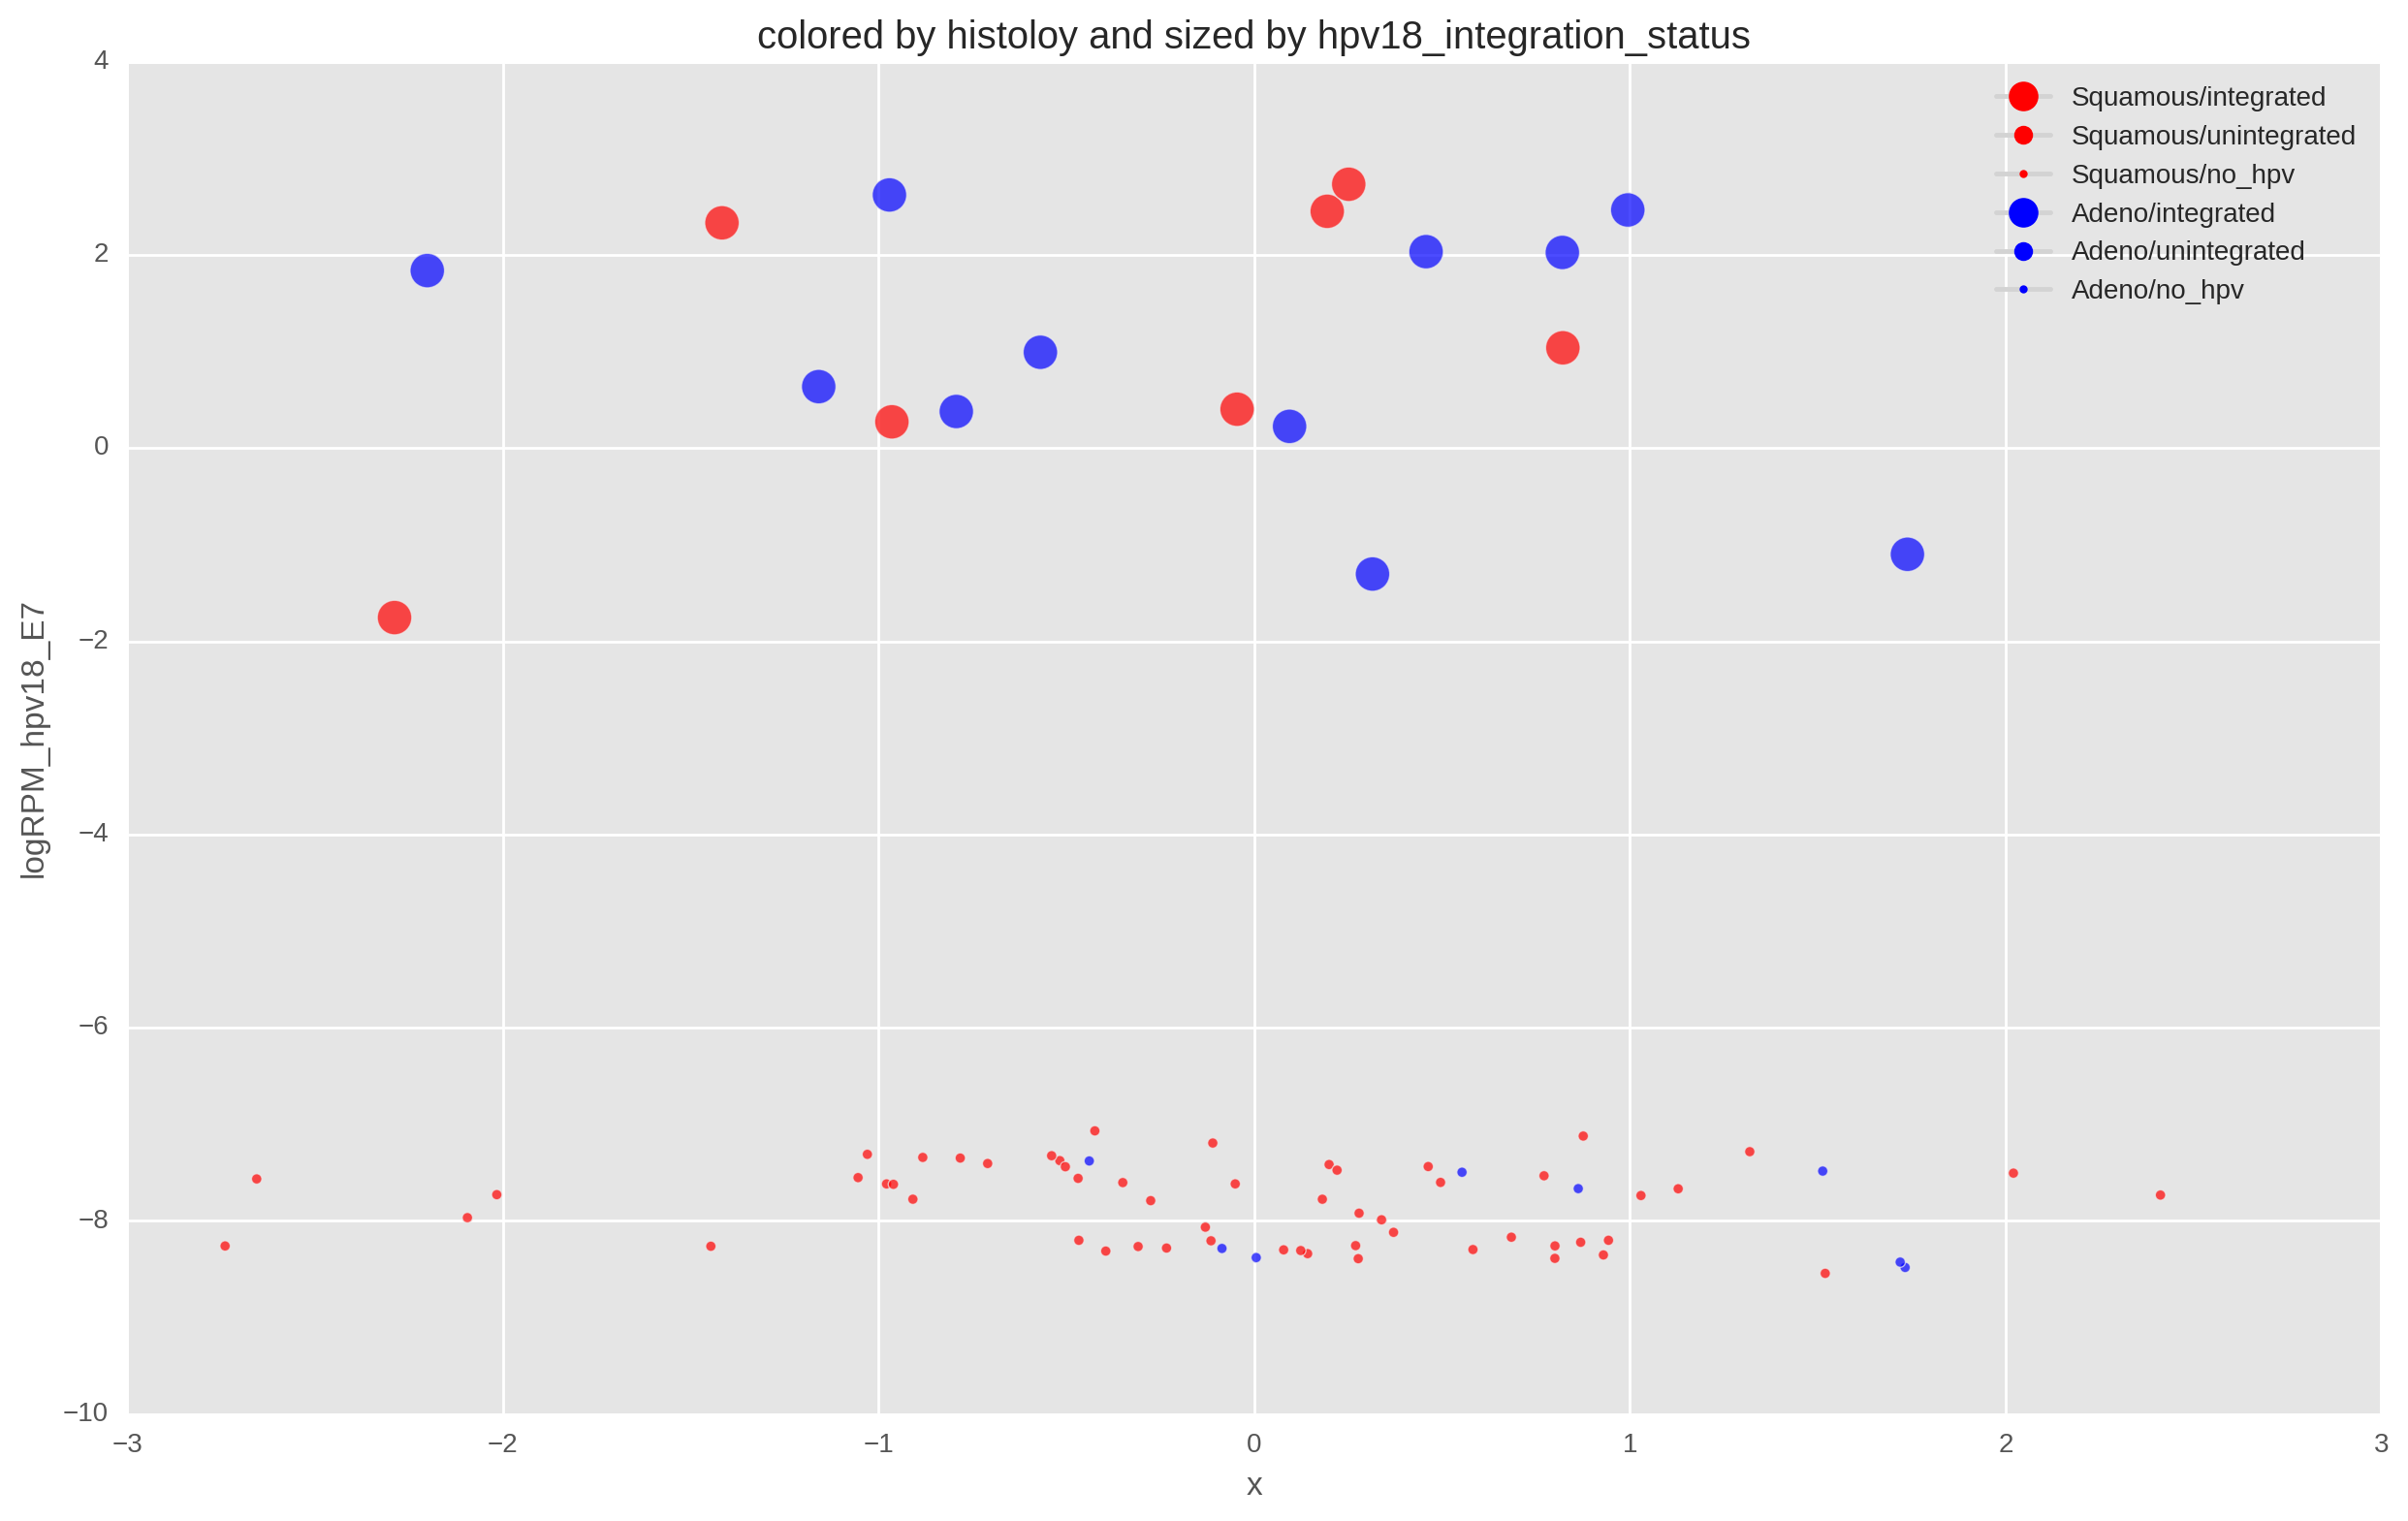

238180486.70731708

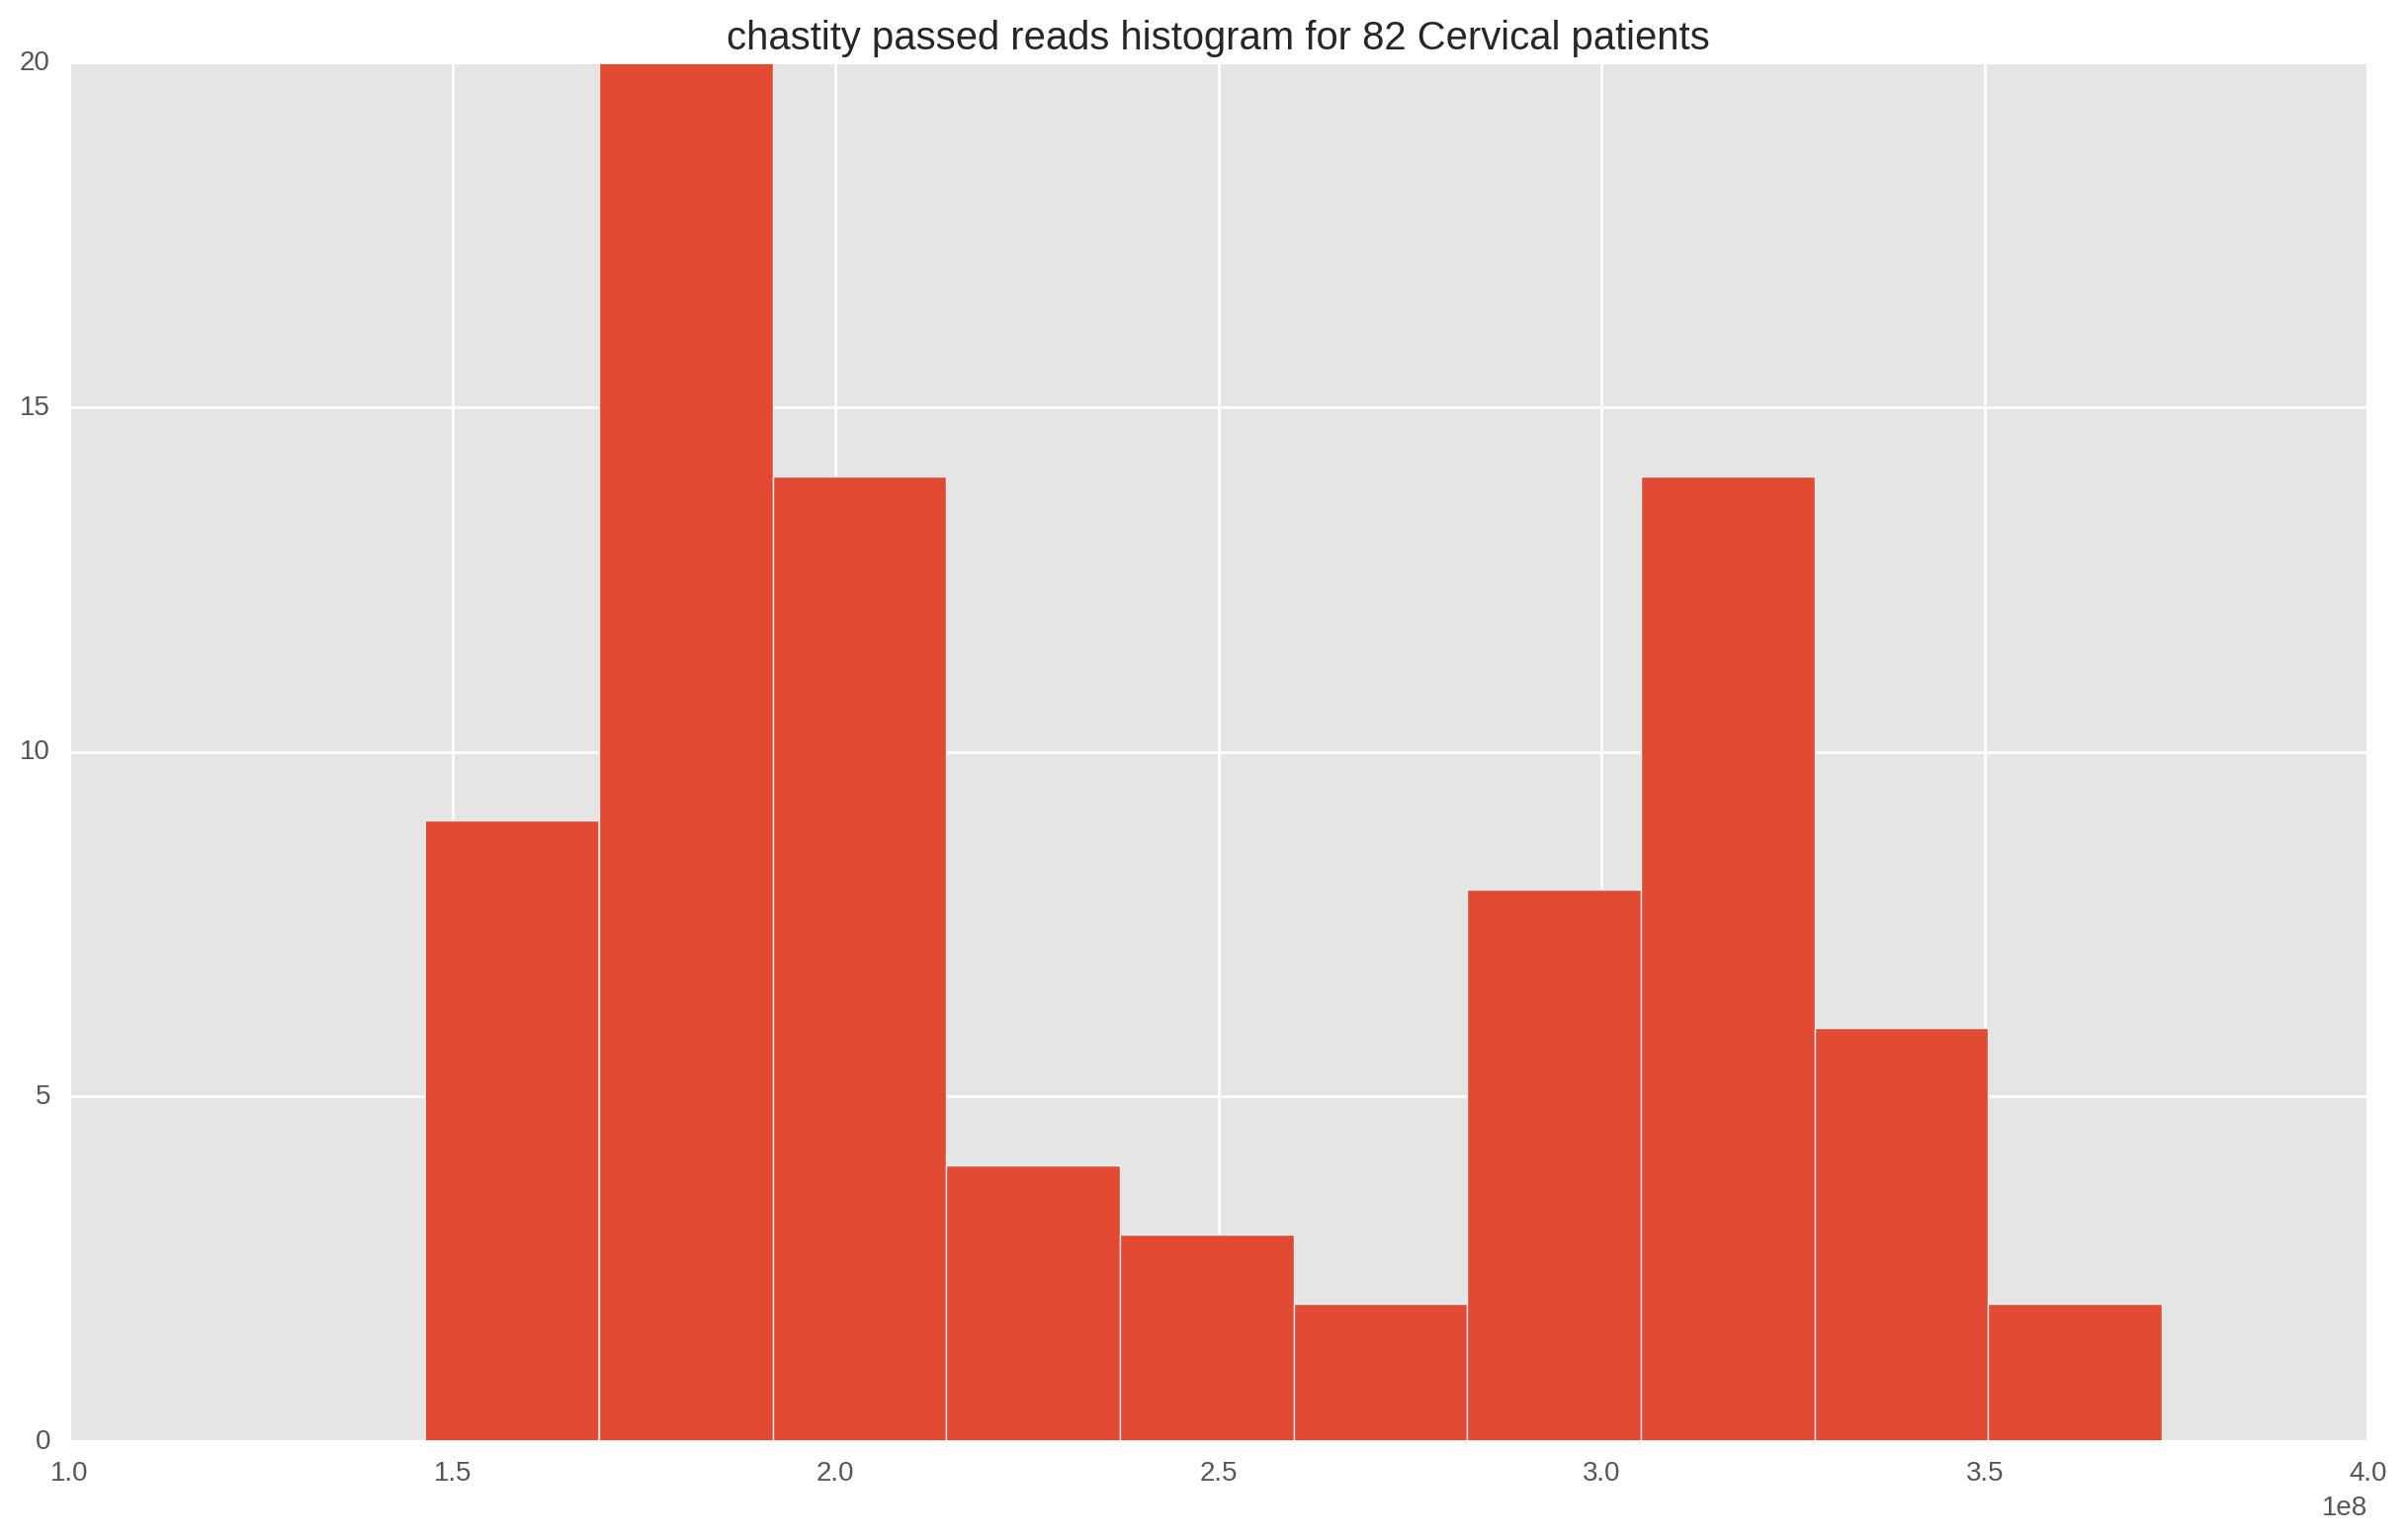

In [59]:
from matplotlib.lines import Line2D
np.random.seed(0)
for gene in viral_genes:
    RPM = '_'.join(['logRPM', gene])
    for intg in intg_statuses:      
        if intg.split('_')[0] in RPM: 
            df_merged['hist_col'] = df_merged['putative_Histology'].map({'Adeno':'blue','Squamous':'red'})
#             df_merged['hist_col'] = df_merged['HIV_status'].map({'Negative':'blue','Positive':'red'})
            df_merged['integration'] = df_merged[intg].map({'integrated':3, 'unintegrated':1, 'no_hpv':0})
            color = df_merged['hist_col']
            df_merged['x'] = np.random.normal(size=82)
            df_merged.plot(kind='scatter', x='x', y=RPM, c=color, s=(df_merged['integration']+0.3)*50, alpha=0.7)
            plt.title('colored by histoloy and sized by {0}'.format(intg))
            
            line1 = Line2D(range(1), range(1), color="lightgray", marker='o', markersize=11, markerfacecolor="red")
            line2 = Line2D(range(1), range(1), color="lightgray", marker='o', markersize=7, markerfacecolor="red")
            line3 = Line2D(range(1), range(1), color="lightgray", marker='o', markersize=3, markerfacecolor="red")
            line4 = Line2D(range(1), range(1), color="lightgray", marker='o', markersize=11, markerfacecolor="blue")
            line5 = Line2D(range(1), range(1), color="lightgray", marker='o', markersize=7, markerfacecolor="blue")
            line6 = Line2D(range(1), range(1), color="lightgray", marker='o', markersize=3, markerfacecolor="blue")
            plt.legend((line1,line2,line3,line4, line5, line6),('Squamous/integrated','Squamous/unintegrated', 'Squamous/no_hpv', 'Adeno/integrated', 'Adeno/unintegrated', 'Adeno/no_hpv'),numpoints=1, loc=1)
            png = '.'.join([gene, intg, 'png'])
#             plt.savefig(png, dpi=200)
            plt.show()


df_merged.chastity_passed_reads.hist()
plt.title('chastity passed reads histogram for 82 Cervical patients')
df_merged.chastity_passed_reads.mean()
plt.savefig('number_RNA_reads_HIV_Cervical.png', dpi=200)

analyze coverage anlaysis based viral expression data generated by Nina's group

# process hpv16 and hpv18 viral expression results

In [564]:
# expr_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv18_expression_files.txt', sep='\t', header=None, index_col=0, names=('lib', 'expr_file'))
#45 hpv16 positives, 44 of them BBT hpv bins are not empty
expr_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv16_expresssion_files.txt', header=None, sep='\t', index_col=0, names=('lib', 'expr_file'))
expr_files.head(2)

df_joined = pd.DataFrame()
for index, row in expr_files.iterrows():
    f = row.expr_file
#     print index, f 
    df_tmp = pd.read_csv(f, sep='\t', header=None)
#     col15=rpkm, col16=gene
    df_e = df_tmp[[14,15]].set_index(15)
    df_e.rename(columns={14:index}, inplace=True)
#     df_e.head(3)
    if df_joined.empty:
         df_joined = df_e
    else:
        df_joined = df_joined.join(df_e, how='outer')
        
df_joined

df_jntT = df_joined.T.sort_values('E7')



df_jntT.reset_index(inplace=True)

,expr_file
lib,
A37700,/projects/tcga_analysis2/GNRG-3805/analysis/A3...
A37702,/projects/tcga_analysis2/GNRG-3805/analysis/A3...


,A37700,A37702,A37706,A37707,A37708,A37714,A37717,A37718,A37723,A37724,...,A54477,A54479,A57112,A57115,A57122,A57123,A68255,A68262,A68267,A68268
15,,,,,,,,,,,,,,,,,,,,,
E1,9.844279,7.610622,13.406793,0.050187,1.164107,20.400884,27.269118,49.990080,77.521539,20.040362,...,211.458194,1.643596,7.820437,1.819108,1.988718,98.024480,23.786498,46.920215,0.656941,1.978219
E1^E4,90.336488,17.386914,32.659660,0.001276,90.222653,77.184714,16.335277,45.733369,294.813812,53.138529,...,4897.231634,14.262206,7.842633,1.281184,0.021420,2.550688,86.358446,69.946927,35.410880,0.506545
E5,0.122812,0.000000,90.126193,0.000000,81.981314,58.733853,17.943105,45.183827,183.113674,146.330542,...,6799.712183,47.352244,13.015231,1.093821,0.000000,0.083919,51.964167,115.573937,24.762045,0.026924
E6,116.457089,51.717553,61.021721,1.099228,76.543279,63.259074,103.878856,165.183575,134.498591,92.331542,...,149.170155,30.336666,15.619987,56.448474,38.817199,422.281825,54.396232,84.665493,35.541998,13.389818
E7,469.430965,191.016264,233.777718,4.110943,280.650069,235.415397,410.096928,689.238651,324.396657,360.357813,...,1792.671793,129.101856,84.347565,197.561948,154.839167,2011.545579,289.290240,410.075622,220.423560,72.862995
E2,36.192318,15.794130,42.854122,0.000000,46.490899,67.076235,16.529544,49.240493,189.791958,65.998612,...,3029.785951,13.369649,11.073936,0.736789,0.770194,0.000000,72.396446,111.431156,21.772733,0.552851
L2,2.686497,0.014396,0.071543,0.000000,25.345666,0.251275,16.445519,17.944978,4.477902,0.770385,...,670.274017,2.204010,2.748907,0.032200,0.003362,8.160299,1.016807,4.086399,0.036604,0.000000
L1,6.534411,0.000000,0.163090,0.000000,38.783104,0.371915,19.457122,24.561932,8.275558,1.214989,...,8014.473078,4.345269,6.639224,0.030163,0.024356,8.452374,1.515721,5.557333,0.065027,0.098687


In [565]:
df_jntT.shape

(44, 9)

In [566]:
# expr_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv18_expression_files.txt', sep='\t', header=None, index_col=0, names=('lib', 'expr_file'))
expr_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv16_expresssion_files.txt', header=None, sep='\t', index_col=0, names=('lib', 'expr_file'))
expr_files.head(2)

df_joined = pd.DataFrame()
for index, row in expr_files.iterrows():
    f = row.expr_file
#     print index, f 
    df_tmp = pd.read_csv(f, sep='\t', header=None)
#     col15=rpkm, col16=gene
    df_e = df_tmp[[14,15]].set_index(15)
    df_e.rename(columns={14:index}, inplace=True)
#     df_e.head(3)
    if df_joined.empty:
         df_joined = df_e
    else:
        df_joined = df_joined.join(df_e, how='outer')
        
df_joined

df_jntT = df_joined.T.sort_values('E7')



df_jntT.reset_index(inplace=True)


,expr_file
lib,
A37700,/projects/tcga_analysis2/GNRG-3805/analysis/A3...
A37702,/projects/tcga_analysis2/GNRG-3805/analysis/A3...


,A37700,A37702,A37706,A37707,A37708,A37714,A37717,A37718,A37723,A37724,...,A54477,A54479,A57112,A57115,A57122,A57123,A68255,A68262,A68267,A68268
15,,,,,,,,,,,,,,,,,,,,,
E1,9.844279,7.610622,13.406793,0.050187,1.164107,20.400884,27.269118,49.990080,77.521539,20.040362,...,211.458194,1.643596,7.820437,1.819108,1.988718,98.024480,23.786498,46.920215,0.656941,1.978219
E1^E4,90.336488,17.386914,32.659660,0.001276,90.222653,77.184714,16.335277,45.733369,294.813812,53.138529,...,4897.231634,14.262206,7.842633,1.281184,0.021420,2.550688,86.358446,69.946927,35.410880,0.506545
E5,0.122812,0.000000,90.126193,0.000000,81.981314,58.733853,17.943105,45.183827,183.113674,146.330542,...,6799.712183,47.352244,13.015231,1.093821,0.000000,0.083919,51.964167,115.573937,24.762045,0.026924
E6,116.457089,51.717553,61.021721,1.099228,76.543279,63.259074,103.878856,165.183575,134.498591,92.331542,...,149.170155,30.336666,15.619987,56.448474,38.817199,422.281825,54.396232,84.665493,35.541998,13.389818
E7,469.430965,191.016264,233.777718,4.110943,280.650069,235.415397,410.096928,689.238651,324.396657,360.357813,...,1792.671793,129.101856,84.347565,197.561948,154.839167,2011.545579,289.290240,410.075622,220.423560,72.862995
E2,36.192318,15.794130,42.854122,0.000000,46.490899,67.076235,16.529544,49.240493,189.791958,65.998612,...,3029.785951,13.369649,11.073936,0.736789,0.770194,0.000000,72.396446,111.431156,21.772733,0.552851
L2,2.686497,0.014396,0.071543,0.000000,25.345666,0.251275,16.445519,17.944978,4.477902,0.770385,...,670.274017,2.204010,2.748907,0.032200,0.003362,8.160299,1.016807,4.086399,0.036604,0.000000
L1,6.534411,0.000000,0.163090,0.000000,38.783104,0.371915,19.457122,24.561932,8.275558,1.214989,...,8014.473078,4.345269,6.639224,0.030163,0.024356,8.452374,1.515721,5.557333,0.065027,0.098687


In [567]:
df_jntT['x'] = df_jntT.index

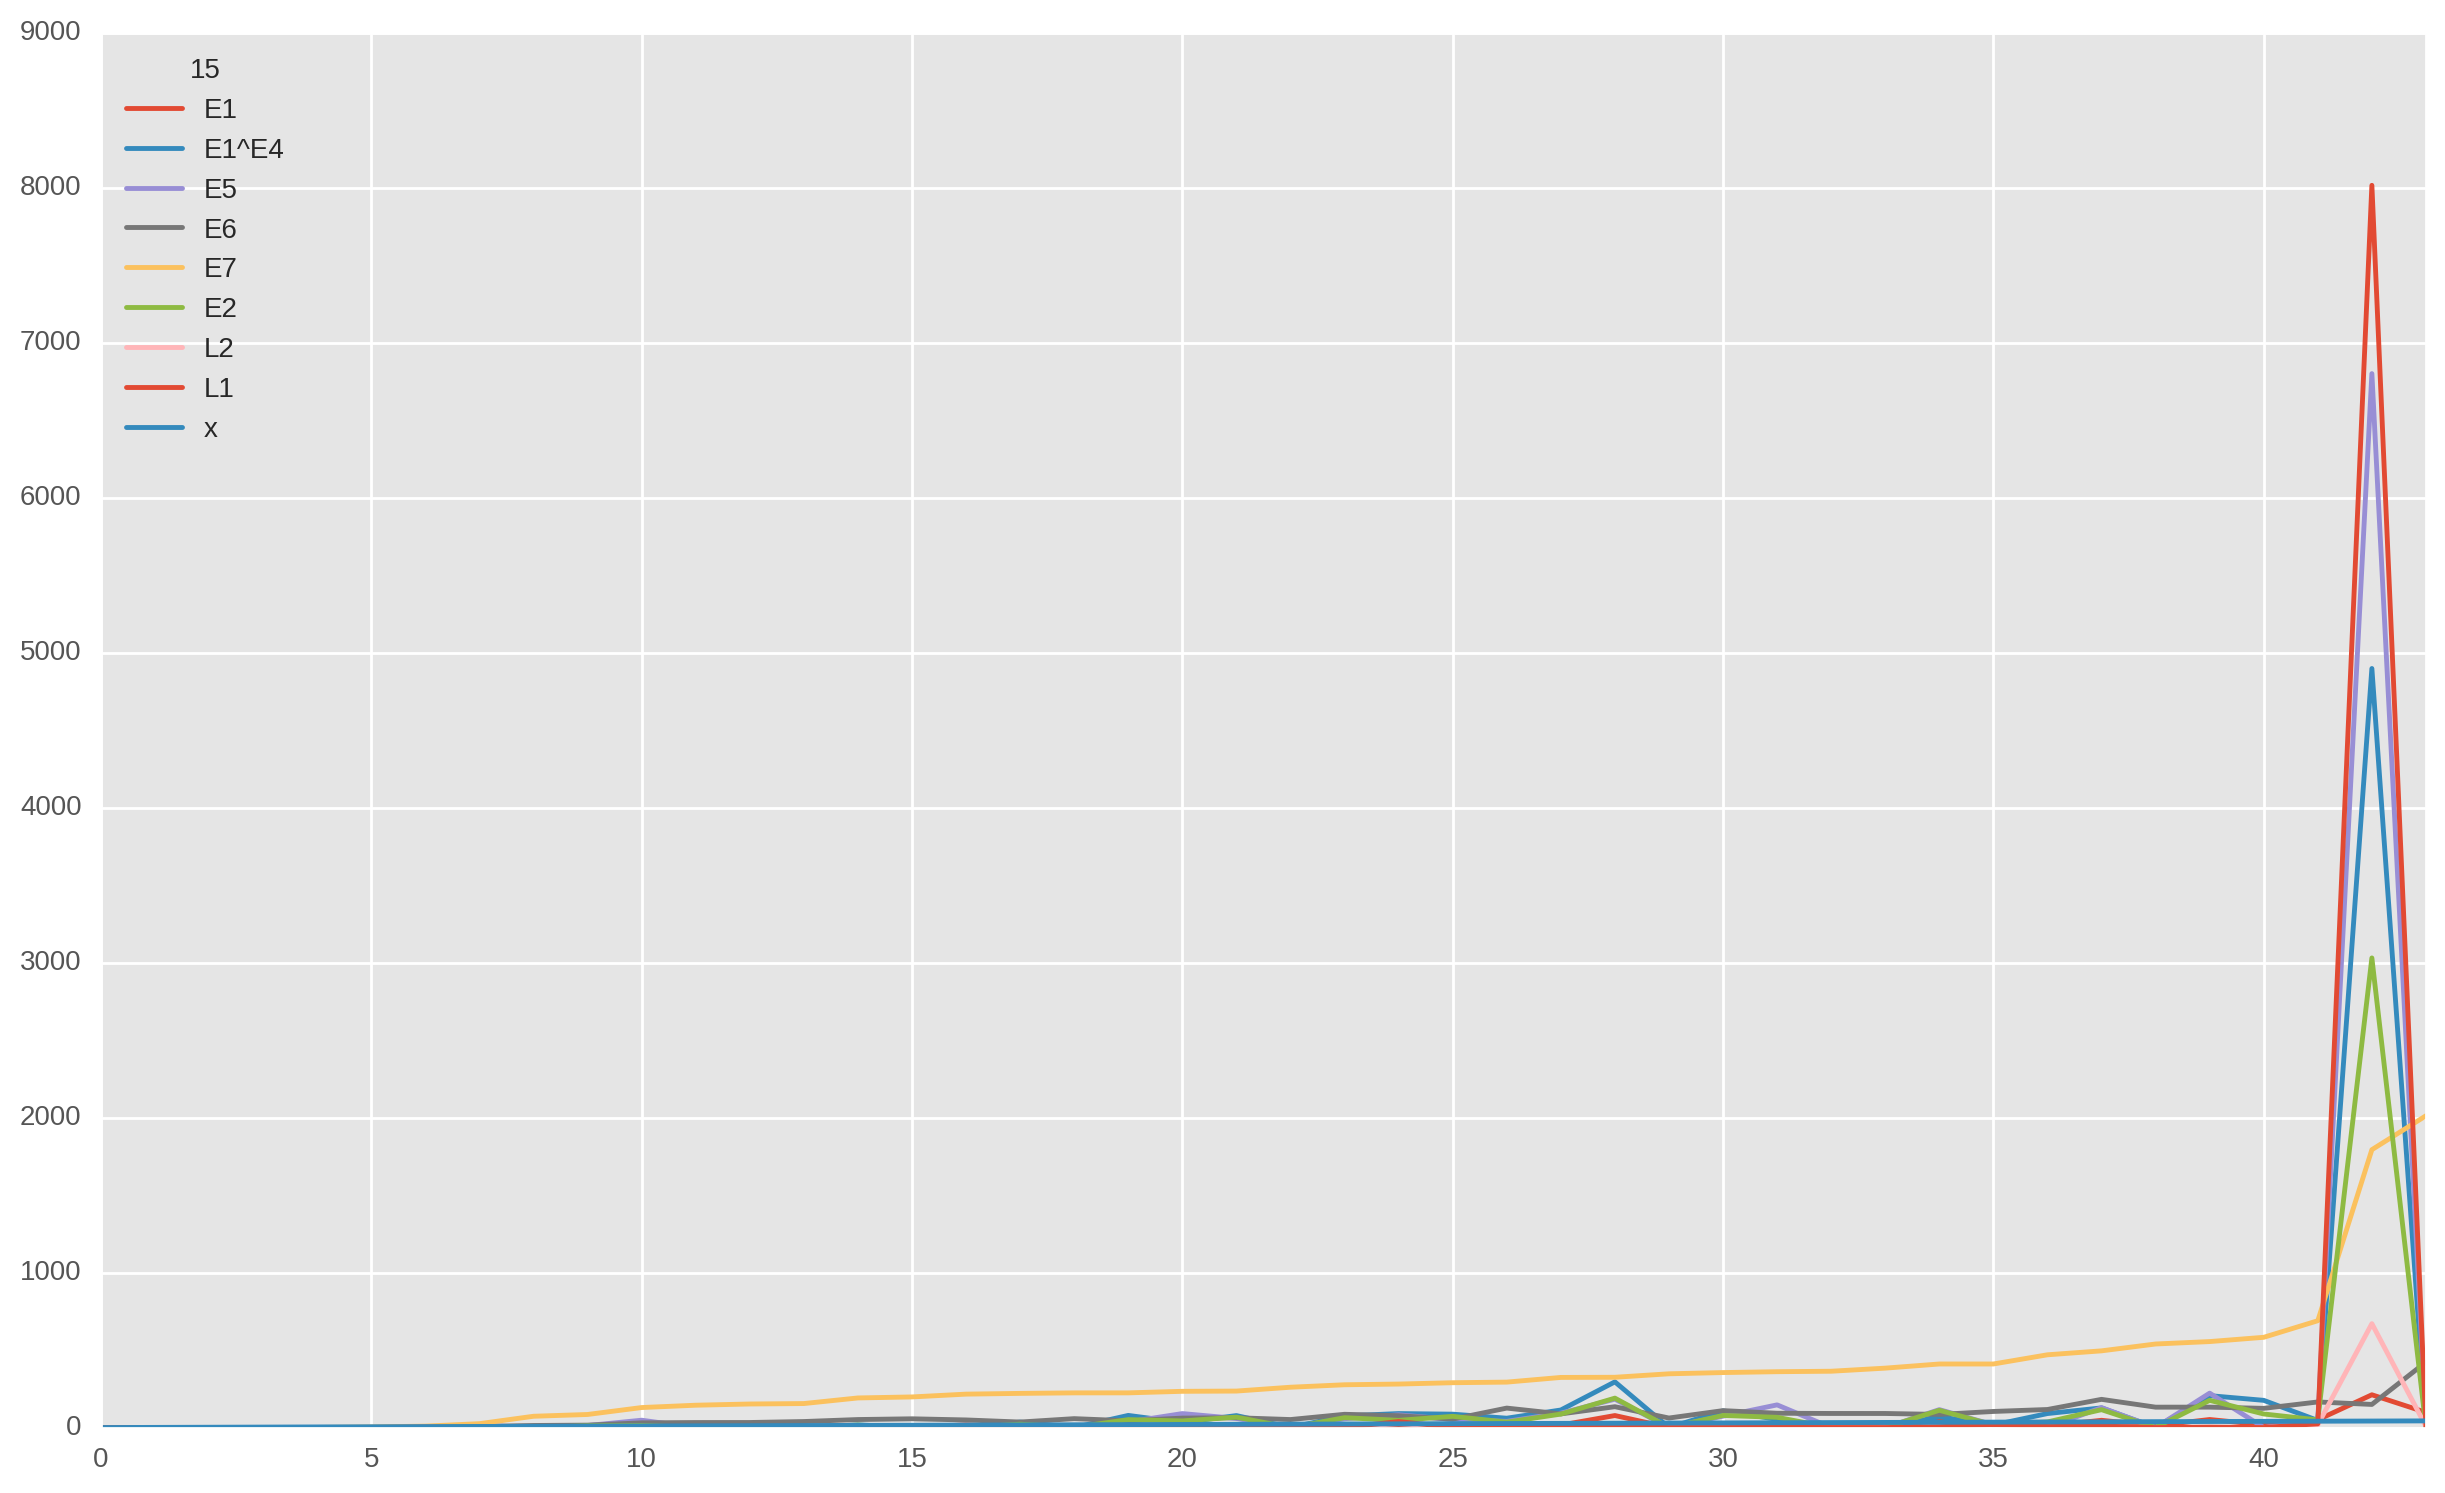

In [568]:

df_jntT.plot()

In [569]:
df_jntT.columns

Index([u'index', u'E1', u'E1^E4', u'E5', u'E6', u'E7', u'E2', u'L2', u'L1',
       u'x'],
      dtype='object', name=15)

In [570]:
# generate N distinct colors
# import colorsys
# N = 10
# HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
# RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)

# RGB_tuples

# color_dict = dict(zip(df_jntT.columns.tolist(), RGB_tuples))
# color_dict

In [571]:
# this is a list of 22 maximum contrast colors:

# hex_codes = ["#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3", "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7", "#f3e1eb", "#f6c4e1", "#f79cd4"]
hex_codes = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#ffff33","#a65628","#f781bf", 'red', 'blue']
color_dict = dict(zip(df_jntT.columns.tolist(), hex_codes))

In [272]:
color_dict

{'E1': '#377eb8',
 'E1^E4': '#4daf4a',
 'E2': '#a65628',
 'E5': '#984ea3',
 'E6': '#ff7f00',
 'E7': '#ffff33',
 'L1': 'red',
 'L2': '#f781bf',
 'index': '#e41a1c',
 'x': 'blue'}

(0, 200)

(-1, 42)

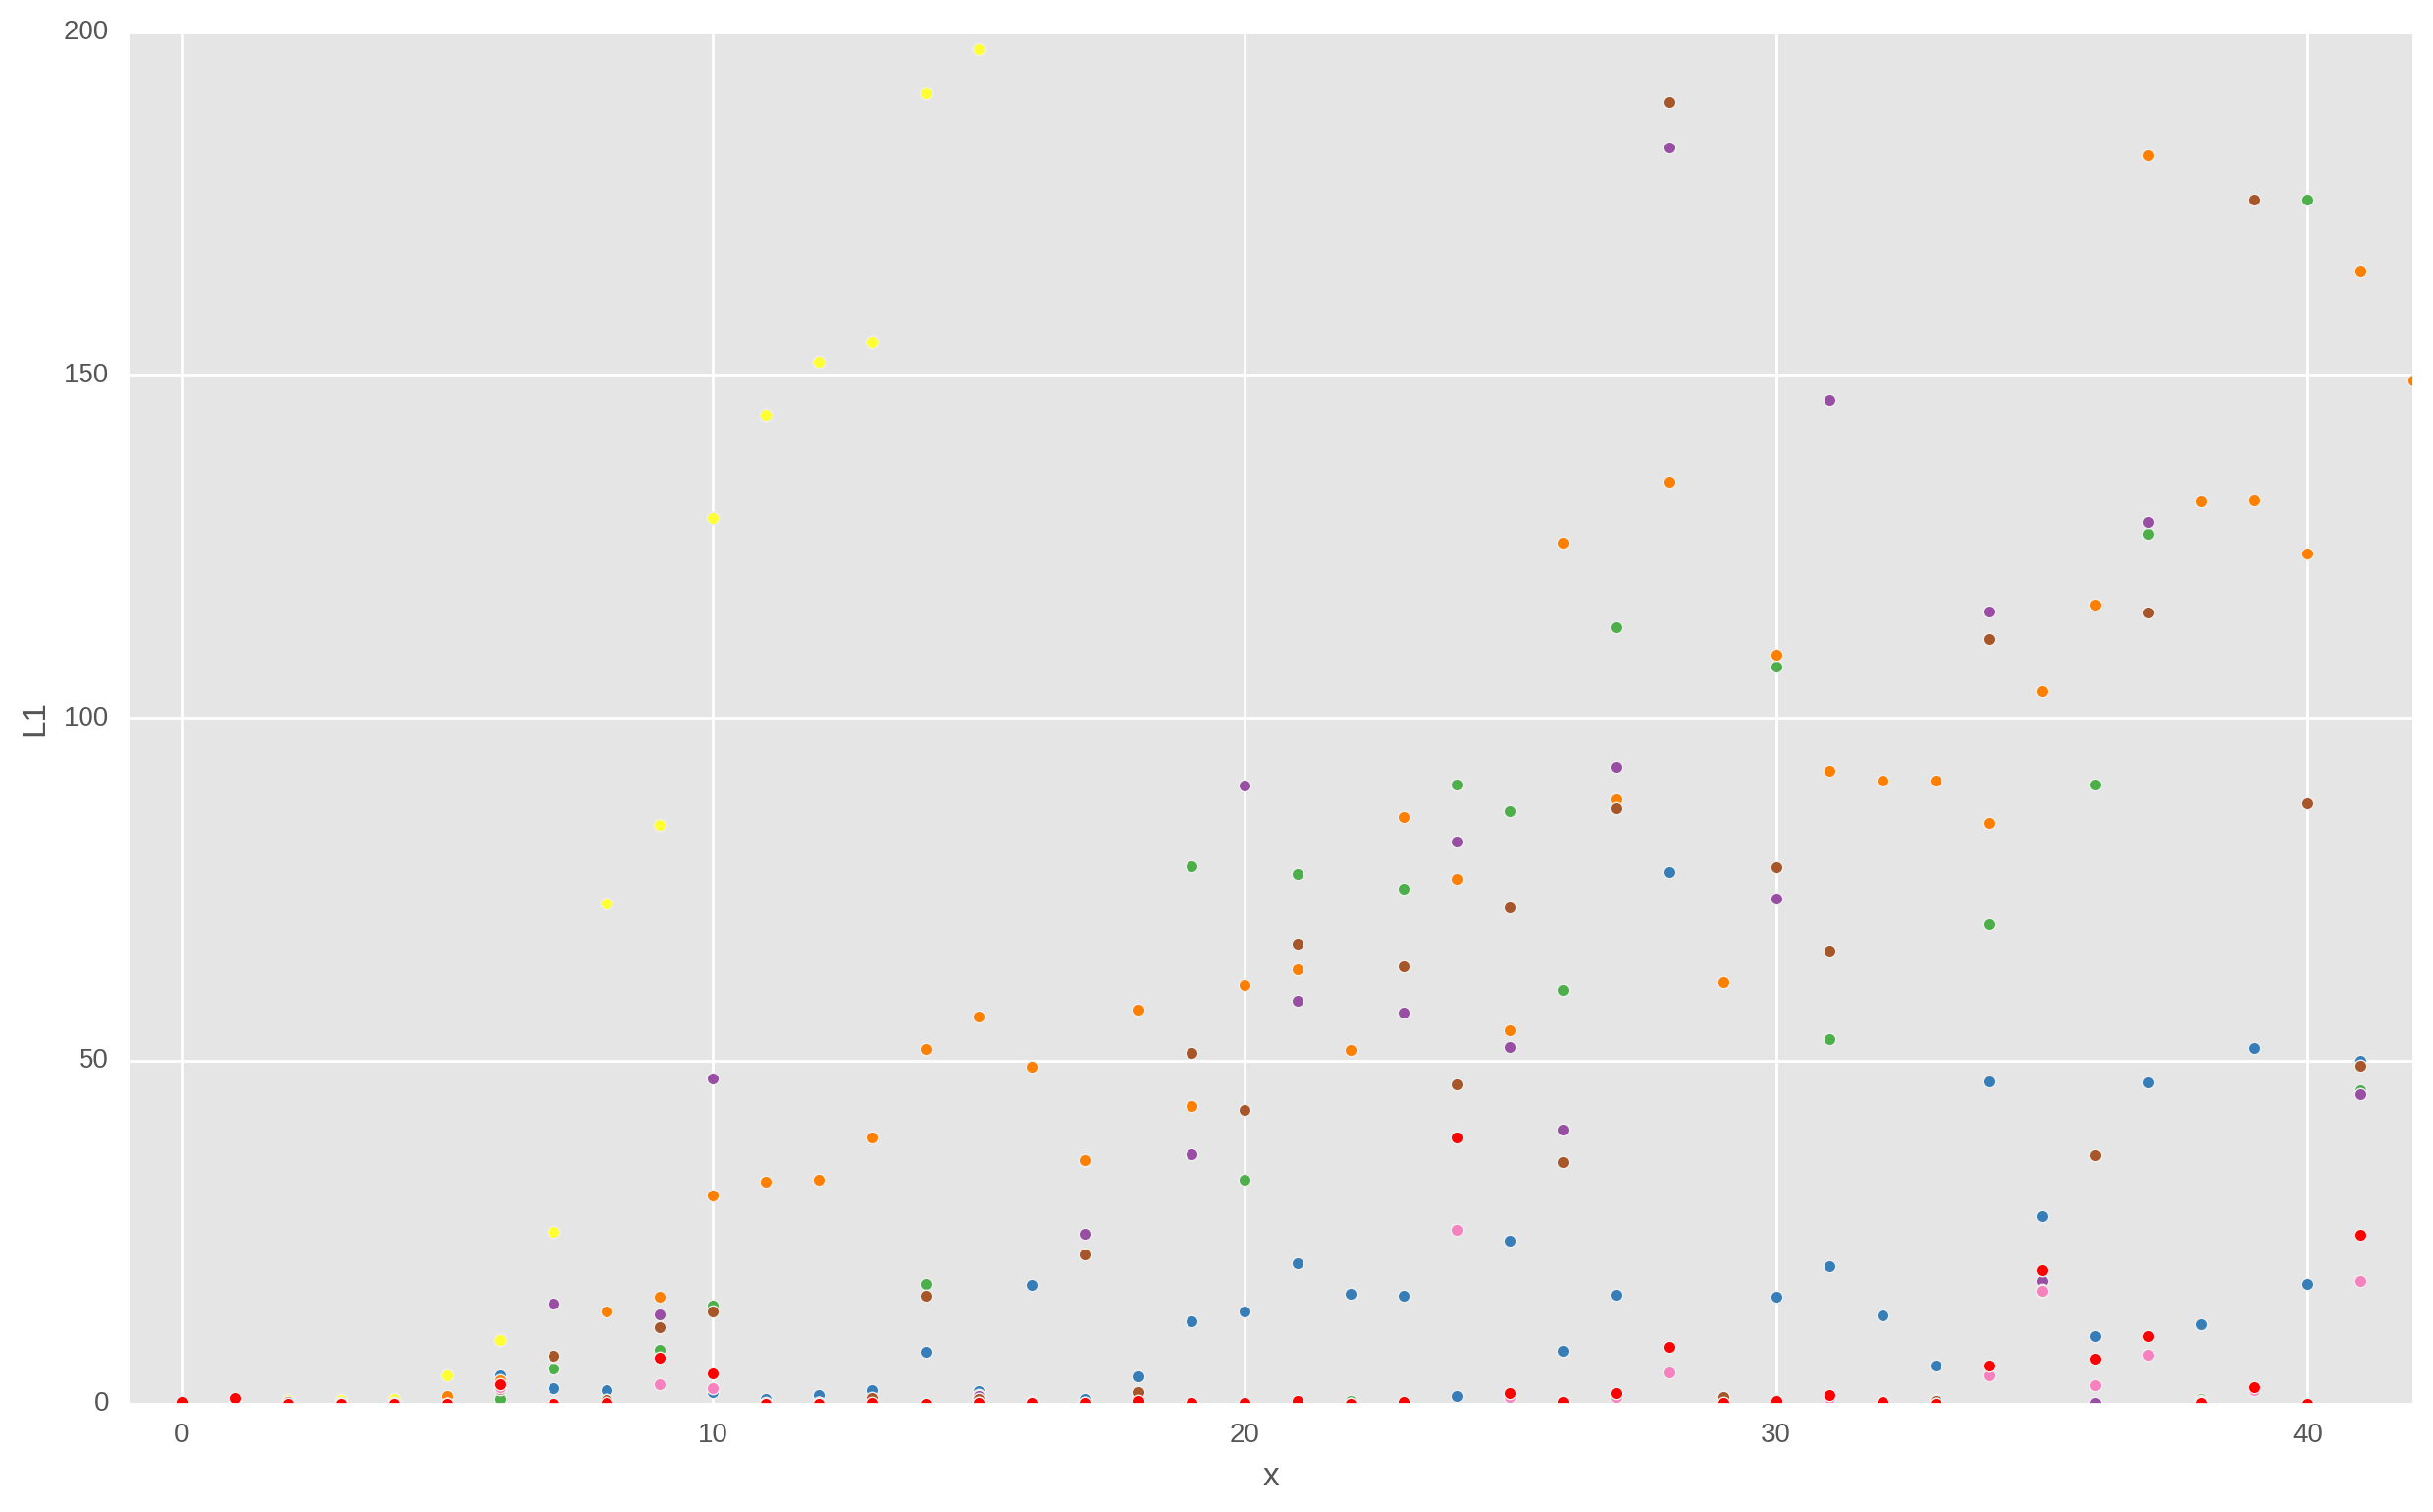

In [273]:
# plot viral genes
ax = df_jntT.plot( 'x', 'E7', kind='scatter', color='black')
ax.set_ylim(0,200)
ax.set_xlim(-1,42)

for col in df_jntT.columns:
    if col != 'index' and col !='x':
        df_jntT.plot('x', col, kind='scatter', ax=ax, color=color_dict[col])

In [95]:
df_merged[['patient', 'logRPM_hpv18_E6', 'logRPM_hpv18_E7']].to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/b.tmp', sep='\t', index=False)

# analyze hpv 16 and hpv 18 expression

In [650]:
# hpv16
# there are only 44 files, 1 detected in dna not run, 1 is in the new 19cases, may be the hpv bin is empty.
# expr_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv16_expresssion_files.txt', header=None, sep='\t', index_col=0, names=('lib', 'expr_file'))
# hpv 18
expr_files = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv18_expression_files.txt', header=None, sep='\t', index_col=0, names=('lib', 'expr_file'))

In [651]:
expr_files.head(2)

,expr_file
lib,
A37719,/projects/tcga_analysis2/GNRG-3805/analysis/A3...
A37722,/projects/tcga_analysis2/GNRG-3805/analysis/A3...


In [652]:
expr_files.shape

(21, 1)

In [653]:
df_joined = pd.DataFrame()
for index, row in expr_files.iterrows():
    f = row.expr_file
#     print index, f 
    df_tmp = pd.read_csv(f, sep='\t', header=None)
#     col15=rpkm, col16=gene
    df_e = df_tmp[[14,15]].set_index(15)
    df_e.rename(columns={14:index}, inplace=True)
#     df_e.head(3)
    if df_joined.empty:
         df_joined = df_e
    else:
        df_joined = df_joined.join(df_e, how='outer')
        
df_joined

,A37719,A37722,A37726,A37730,A37731,A37732,A37737,A50336,A50338,A50339,...,A52344,A52353,A52354,A52362,A54473,A57113,A57121,A62929,A68253,A68258
15,,,,,,,,,,,,,,,,,,,,,
E1,13.336610,3.576391,1.752661,7.572706,0.088750,0.245989,23.219920,24.387752,6.327860,33.862525,...,2.581369,14.703182,87.980406,6.387431,3.345013,2.207321,5.835367,4.278747,27.361186,36.392494
E2,11.629879,0.722735,89.740574,1.284161,0.000000,0.000000,62.096759,110.559497,15.764513,65.621751,...,0.000000,11.584050,1.640898,0.920763,7.341144,0.000000,8.671167,145.556533,16.537772,0.749238
E4,0.000000,0.586340,177.584298,0.000000,0.000000,0.000000,58.561021,57.436586,7.030101,47.590627,...,0.000000,14.230553,0.035113,0.000000,3.564244,0.000000,6.889817,363.103540,13.317413,0.394130
E5,206.059874,0.471701,351.023232,0.000000,0.000000,0.000000,55.866743,61.947897,0.000000,33.849090,...,0.000000,15.236841,0.205829,0.000000,3.301451,0.000000,3.139401,231.944891,9.184189,0.491669
E6,17.028105,25.232512,20.375459,54.686942,7.684216,26.567080,12.810779,33.029330,23.262257,52.214956,...,58.737809,30.705086,71.893894,11.622820,15.878568,96.486622,13.905769,38.764769,33.345148,22.354404
E7,63.219841,91.803418,222.074968,263.803481,18.622316,84.263615,73.550265,198.307642,151.506779,161.049952,...,158.982696,13.197344,264.094563,20.134706,49.829826,226.395340,48.625511,422.205294,151.154580,112.478131
L1,0.149320,5.061847,0.431739,0.000000,0.000000,0.105776,4.185985,0.038399,0.000000,6.624047,...,0.000000,5.327371,0.000000,0.030826,0.082078,0.138253,1.548948,0.493425,0.962317,0.022951
L2,0.085789,0.001932,0.159084,0.000000,0.000000,0.014072,1.288891,0.034154,0.000000,0.676932,...,0.000000,1.073553,0.000000,0.000000,0.038033,0.000000,0.076488,0.251429,0.190350,0.011282


In [654]:
df_jntT = df_joined.T

In [655]:
# get virus_gene types
genes_todrop = df_jntT.columns.tolist()
viral_genes =['E6', 'E7']

In [656]:
for gene in viral_genes:
#     print(gene)
    RPKM = '_'.join(['logRPKM', gene])
    df_jntT[RPKM] = np.log10(df_jntT[gene]+1)

In [657]:
df_jntT.drop(genes_todrop, axis=1, inplace=True)

In [658]:
df_jntT.head(2)

15,logRPKM_E6,logRPKM_E7
A37719,1.25595,1.807669
A37722,1.41884,1.967564


In [659]:
df_jntT=df_jntT.sort_values('logRPKM_E7')


In [660]:
# add in patient id into the dataframe
df_pat = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/101_patients_vcfs_bams.csv')
df_pat = df_pat[['patient', 'RNA_lib']]
df_pat.head(2)

,patient,RNA_lib
0,HTMCP-03-06-02001,A37700
1,HTMCP-03-06-02002,A37701


In [661]:
df_jntT = pd.merge(df_jntT, df_pat, left_index=True, right_on='RNA_lib')

In [662]:
df_jntT.set_index('patient', inplace=True)

In [663]:
df_jntT = df_jntT.drop('RNA_lib', axis=1)

In [664]:
np.arange(len(df_jntT.index.tolist()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [587]:
# plt.legend?
plt.plot?

In [665]:
df_jntT.head(2)

15,logRPKM_E6,logRPKM_E7
patient,,
HTMCP-03-06-02180,1.501129,1.152207
HTMCP-03-06-02075,0.938731,1.292750


In [666]:
# add in RNA bbt read counts
df_counts = pd.read_excel('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/Cervical_integration_expression_mastertable_reviewed.xls', index_col='patient')
#                          parse_cols=['HPV_read_pairs_RNA_BBT'])

In [667]:
df_counts = pd.DataFrame(df_counts[['HPV_read_pairs_RNA_BBT', 'number_of_HPV_strains']])

df_counts['logHPV_reads'] = np.log10(df_counts['HPV_read_pairs_RNA_BBT']+1)
df_counts.drop('HPV_read_pairs_RNA_BBT', axis=1, inplace=True)
df_counts.head(2)

,number_of_HPV_strains,logHPV_reads
patient,,
HTMCP-03-06-02202,1,3.699144
HTMCP-03-06-02240,1,4.806858


In [668]:
df_jntT.head(2)

15,logRPKM_E6,logRPKM_E7
patient,,
HTMCP-03-06-02180,1.501129,1.152207
HTMCP-03-06-02075,0.938731,1.292750


In [669]:
new_df = pd.merge(df_jntT, df_counts, left_index=True, right_index=True, how='inner')

In [670]:
new_df.shape

(21, 4)

In [671]:
new_df.head(2)

15,logRPKM_E6,logRPKM_E7,number_of_HPV_strains,logHPV_reads
patient,,,,
HTMCP-03-06-02103,1.531853,2.299524,3,4.248415
HTMCP-03-06-02179,1.227336,1.706119,2,3.406370


In [672]:
df_jntT = new_df

In [673]:
df_jntT=df_jntT.sort_values('logRPKM_E7')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

(array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Text yticklabel objects>)

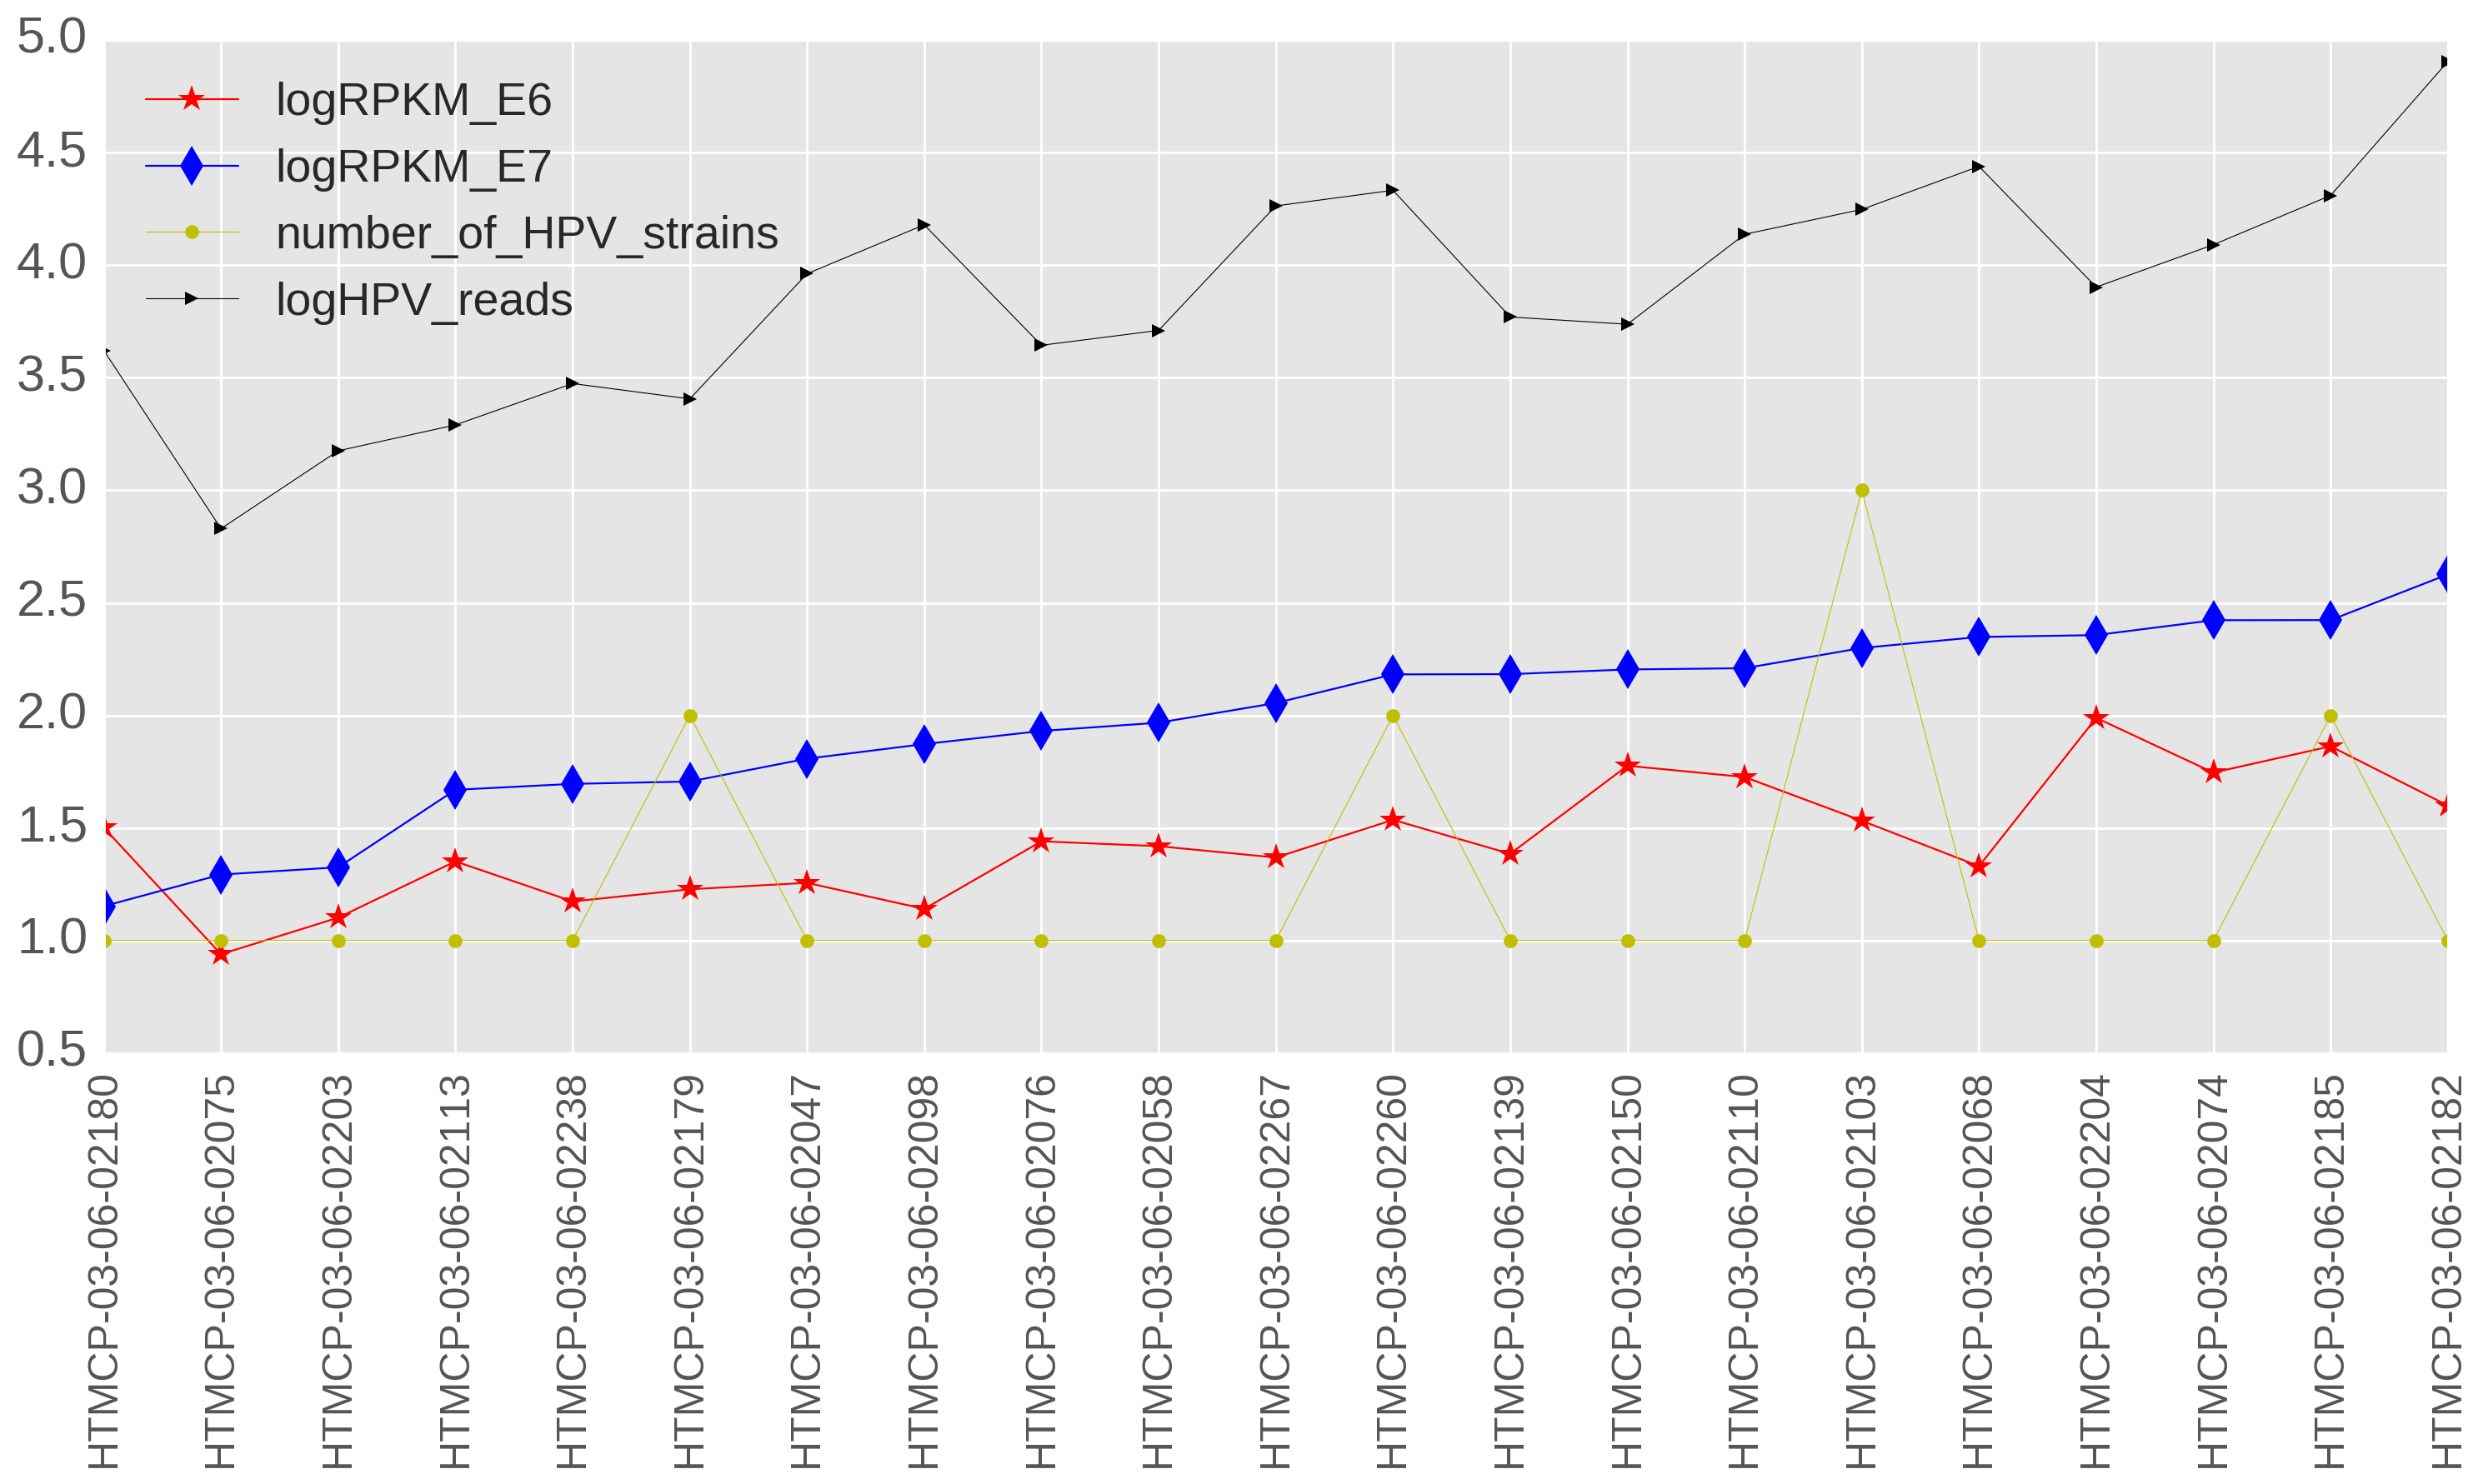

In [674]:
# colors:
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
#styles = ['ys-','yo-','y^-','r*-','bd-','yp-','yx-','y+-','y.-','y|-']

# use this for hpv16
# linewidths = [0.3, 0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3]
# styles = ['ys-','yo-','y^-','r*-','bd-','yv-','k<-','kp-','y>-','y<-']

# use this for hpv18
# styles = ['ys-','yo-','y^-', 'yv-','r*-','bd-','k<-','kp-','y>-','y<-']
styles = ['r*-', 'bd-', 'yo-','k>-']
# linewidths = [0.3, 0.3, 0.3, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
linewidths =[0.8,0.8, 0.4, 0.4]
mksizes=[12,12,6,6]
fig, ax = plt.subplots()
# let it show all x tick labels
ax.set_xticks(np.arange(len(df_jntT.index.tolist())))
# ax.set_xticklabels(df_jntT.index.tolist())
# ax.set_ylim(0,900)
for col, style, lw , mksize in zip(df_jntT.columns, styles, linewidths, mksizes):
    df_jntT[col].plot(style=style, lw=lw, ax=ax, markersize=mksize);
# df_jntT[df_jntT.columns.tolist()[8:]].sort_values('logRPM_E7').plot()
plt.xticks(rotation='vertical', fontsize=18)
plt.yticks(fontsize=22)
ax.set_xlabel('  ')
# ax.set_ylabel('viral expression')
plt.legend(loc=2, fontsize=20)
plt.tight_layout()
plt.savefig('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/hpv18_expression.png', dpi=200)
# df_jntT[df_jntT.columns.tolist()[8:]].sort_values('logRPM_E7').plot()

In [486]:
for i in df_jntT.index.tolist():
    print i

HTMCP-03-06-02149
HTMCP-03-06-02175
HTMCP-03-06-02185
HTMCP-03-06-02179
HTMCP-03-06-02103
HTMCP-03-06-02012
HTMCP-03-06-02097
HTMCP-03-06-02151
HTMCP-03-06-02333
HTMCP-03-06-02202
HTMCP-03-06-02213
HTMCP-03-06-02125
HTMCP-03-06-02210
HTMCP-03-06-02239
HTMCP-03-06-02003
HTMCP-03-06-02217
HTMCP-03-06-02215
HTMCP-03-06-02332
HTMCP-03-06-02155
HTMCP-03-06-02174
HTMCP-03-06-02008
HTMCP-03-06-02036
HTMCP-03-06-02196
HTMCP-03-06-02144
HTMCP-03-06-02013
HTMCP-03-06-02262
HTMCP-03-06-02128
HTMCP-03-06-02147
HTMCP-03-06-02109
HTMCP-03-06-02194
HTMCP-03-06-02108
HTMCP-03-06-02061
HTMCP-03-06-02071
HTMCP-03-06-02209
HTMCP-03-06-02322
HTMCP-03-06-02042
HTMCP-03-06-02001
HTMCP-03-06-02176
HTMCP-03-06-02063
HTMCP-03-06-02214
HTMCP-03-06-02148
HTMCP-03-06-02046
HTMCP-03-06-02205
HTMCP-03-06-02240


In [311]:
# hpv16
# 5 Lowest expressors are all unintegrated
# HTMCP-03-06-02149
# HTMCP-03-06-02175
# HTMCP-03-06-02185
# HTMCP-03-06-02179
# HTMCP-03-06-02103


# These are the 11 hpv16 un-integrated cases
# HTMCP-03-06-02217
# HTMCP-03-06-02239
# HTMCP-03-06-02036
# HTMCP-03-06-02061
# HTMCP-03-06-02144
# HTMCP-03-06-02103
# HTMCP-03-06-02179
# HTMCP-03-06-02185
# HTMCP-03-06-02149
# HTMCP-03-06-02175
# HTMCP-03-06-02008

# hpv18
# all integrated except 02012, 2 short identical contigs 100% aligned to hpv18, no integration evidence

In [312]:
# df_jntT.sort_values('logRPM_E7')

# hpv18 expression

In [14]:
# random stuff, please note currently the qsub scripts are still not working

In [59]:
df = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/mutsigcv/snv.vcf2maf.sh', sep=' ', header=None)
# df = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/mutsigcv/indel.vcf2maf.sh', sep=' ', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,perl,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--input-vcf,NaN,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...,--output-maf,HTMCP-03-06-02001.snv.maf,--tumor-id,NaN,HTMCP-03-06-02001_T,--normal-id,HTMCP-03-06-02001_N,--vep-path,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--vep-data,/projects/analysis/vepdata,--output-directory,.
1,perl,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--input-vcf,NaN,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...,--output-maf,HTMCP-03-06-02002.snv.maf,--tumor-id,NaN,HTMCP-03-06-02002_T,--normal-id,HTMCP-03-06-02002_N,--vep-path,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--vep-data,/projects/analysis/vepdata,--output-directory,.
2,perl,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--input-vcf,NaN,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...,--output-maf,HTMCP-03-06-02003.snv.maf,--tumor-id,NaN,HTMCP-03-06-02003_T,--normal-id,HTMCP-03-06-02003_N,--vep-path,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--vep-data,/projects/analysis/vepdata,--output-directory,.
3,perl,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--input-vcf,NaN,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...,--output-maf,HTMCP-03-06-02006.snv.maf,--tumor-id,NaN,HTMCP-03-06-02006_T,--normal-id,HTMCP-03-06-02006_N,--vep-path,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--vep-data,/projects/analysis/vepdata,--output-directory,.
4,perl,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--input-vcf,NaN,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...,--output-maf,HTMCP-03-06-02007.snv.maf,--tumor-id,NaN,HTMCP-03-06-02007_T,--normal-id,HTMCP-03-06-02007_N,--vep-path,/gsc/software/linux-x86_64-centos6/vcf2maf-1.6...,--vep-data,/projects/analysis/vepdata,--output-directory,.


In [60]:
from jinja2 import Environment, FileSystemLoader


def populate_sh_template(template_dir, sh_script, patient, input_vcf, output_maf):
    jinja2_env = Environment(loader=FileSystemLoader([template_dir]),
                             trim_blocks=True)
    template = jinja2_env.get_template('vcf2maf_template.sh')
    with open(sh_script, 'w') as opf:
        content = template.render(patient=patient,
                                  input_vcf=input_vcf,
                                  output_maf=output_maf)
        opf.write(content)
        print('templated {}'.format(sh_script))
    return sh_script

In [61]:
template_dir = '/home/szong/projects/development/mutsigcv/'


In [62]:
import os
os.chdir('/projects/trans_scratch/validations/workspace/szong/Cervical/mutsigcv/mafs')

In [63]:
!pwd

/projects/trans_scratch/validations/workspace/szong/Cervical/mutsigcv/mafs


In [2]:
for index, row in df.iterrows():
    patient=row[9].split('_')[0]
#     sh_script = '.'.join([patient,'indel', 'sh'])
    sh_script = '.'.join([patient,'snv', 'sh'])
    input_vcf = row[4]
#     output_maf = '.'.join([patient, 'indel', 'maf'])
    output_maf = '.'.join([patient, 'snv', 'maf'])
#     populate_sh_template(template_dir, sh_script, patient, input_vcf, output_maf);



NameError: name 'df' is not defined

# process hpv integration file for R comut plot

In [438]:
df_sum = pd.read_excel('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/Cervical_integration_expression_mastertable_reviewed.xls')

In [439]:
df_sum.head(2)

,patient,hiv_nationwide,cd4counts_nationwide,hist_nationwide,keratinization_nationwide,dna_library,source_ID,putative_Histology,library_RNA,RNA_all_strains_integration_status,...,hist_col,integration,x,hpv16_2_E6,hpv16_2_E7,hpv16_E6,hpv16_E7,hpv18_E6,hpv18_E7,rna_chastity_passed_reads
0,HTMCP-03-06-02202,Positive,437,squamouscellcarcinoma,Keratinizing,A57085,HTMCP_400,Squamous,A57112,integrated,...,red,0,-0.7,1237.2,4162.1,1315.8,4155.4,0,0,307193606
1,HTMCP-03-06-02240,Positive,611,squamouscellcarcinoma,Non-Keratinizing,A57096,HTMCP_411,Squamous,A57123,integrated,...,red,0,-1,0,0,0,0,0,0,311167934


In [440]:
df_sum.shape

(101, 45)

In [441]:
# df_sum = df_sum[['patient', 'HIV_status', 'HPV_strains_RNA_contig', 'integration_RNA_contig']]
df_sum = df_sum[['patient', 'HIV_status', 'putative_Histology', 'combined_hpv_results_from_all_tools_and_reviewed', 'combined_integration_status']]
df_sum.set_index('patient', inplace=True)
df_sum.head(3)

,HIV_status,putative_Histology,combined_hpv_results_from_all_tools_and_reviewed,combined_integration_status
patient,,,,
HTMCP-03-06-02202,Positive,Squamous,APV_9;HPV_16,NO;YES
HTMCP-03-06-02240,Positive,Squamous,APV_9;HPV_16,NO;YES
HTMCP-03-06-02174,Negative,Squamous,HPV_16,YES


In [442]:
# df_sum.loc['HTMCP-03-06-02202', ['HPV_strains_RNA_contig', 'integration_RNA_contig']]
# This is how you access a element in a dataframe
# df_sum.loc[['HTMCP-03-06-02202', 'HTMCP-03-06-02240'], ['HPV_strains_RNA_contig', 'integration_RNA_contig']]

In [443]:
# This does not give correct resulting dataframe

def process_row(row):
#     res = dict(zip(row.HPV_strains_RNA_contig.split(';'),
#                    row.integration_RNA_contig.split(';')))
    res = dict(zip(row.combined_hpv_results_from_all_tools_and_reviewed.split(';'),
                      row.combined_integration_status.split(';')))
    res.update(patient=row.name)

#     print res
    return res

res = df_sum.apply(process_row, axis=1)

ndf = pd.DataFrame(res.values.tolist()).fillna('NA').set_index('patient', drop=True)
# _ndf = pd.DataFrame.from_dict(res.values.tolist()).fillna('NO').set_index('patient', drop=True)

In [444]:
ndf.head(2)

,APV_9,HPV_16,HPV_18,HPV_26,HPV_31,HPV_33,HPV_34,HPV_35,HPV_39,HPV_45,...,HPV_52,HPV_53,HPV_58,HPV_59,HPV_68,HPV_69,HPV_73,HPV_82,HPV_9,NOHPV
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02202,NO,YES,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HTMCP-03-06-02240,NO,YES,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [445]:
# # another way to do this
# # get all strains
# lst = [i.split(';') for i in df_sum['combined_hpv_results_from_all_tools_and_reviewed']]

# strains = [item for sublst in lst for item in sublst]

# strains = list(set(strains))

# strains

In [446]:
ndf.HPV_16.to_csv('aa.tmp', sep="\t")

In [447]:
pwd

u'/home/szong/projects/development/study'

In [448]:
df_meta = df_sum[['HIV_status', 'putative_Histology']]
ndf = ndf.join(df_meta)
ndf.head(2)

,APV_9,HPV_16,HPV_18,HPV_26,HPV_31,HPV_33,HPV_34,HPV_35,HPV_39,HPV_45,...,HPV_58,HPV_59,HPV_68,HPV_69,HPV_73,HPV_82,HPV_9,NOHPV,HIV_status,putative_Histology
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02202,NO,YES,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Positive,Squamous
HTMCP-03-06-02240,NO,YES,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Positive,Squamous


In [449]:
ndf.HPV_16.value_counts()

NA       55
YES      29
NO       12
MAYBE     5
Name: HPV_16, dtype: int64

In [450]:
ndf.drop('NOHPV', axis=1, inplace=True)

In [451]:
# drop apv_9: human papillomavirus have 5 genus: alpha , beta, gamma, nupa, mupa
# hpv16 is a type in apv9 and hpv18 is a type in apv7. apv's natural host is human and monkey.
ndf.drop('APV_9', axis=1, inplace=True)

In [452]:
ndf.columns

Index([u'HPV_16', u'HPV_18', u'HPV_26', u'HPV_31', u'HPV_33', u'HPV_34',
       u'HPV_35', u'HPV_39', u'HPV_45', u'HPV_51', u'HPV_52', u'HPV_53',
       u'HPV_58', u'HPV_59', u'HPV_68', u'HPV_69', u'HPV_73', u'HPV_82',
       u'HPV_9', u'HIV_status', u'putative_Histology'],
      dtype='object')

In [453]:
# reorder columns and rows based on lists
# df_test = ndf.head()
# df.reindex(["Z", "C", "A"])

In [454]:
# df_test.index.tolist()
# sorter = [u'HTMCP-03-06-02174',
#  u'HTMCP-03-06-02240',
#  u'HTMCP-03-06-02202',
#  u'HTMCP-03-06-02128',
#  u'HTMCP-03-06-02151']

In [455]:
# generate a customized patient list for the comutplot
df_pats = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/HIV_Cervical_101_patients.txt.histology.sorted', header=None)
patient_sorter = df_pats[0].tolist()

In [456]:
ndf = ndf.reindex(patient_sorter)
ndf.head(2)

,HPV_16,HPV_18,HPV_26,HPV_31,HPV_33,HPV_34,HPV_35,HPV_39,HPV_45,HPV_51,...,HPV_53,HPV_58,HPV_59,HPV_68,HPV_69,HPV_73,HPV_82,HPV_9,HIV_status,putative_Histology
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02007,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Negative,Adeno
HTMCP-03-06-02026,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Negative,Adeno


In [457]:
# generate a customized hpv list for the comut plot
df_hpv = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/integration/101_patients/ordered_hpv_list.txt', header=None)
df_hpv.head(2)
hpv_sorter = df_hpv[0].tolist()

,0
0,putative_Histology
1,HIV_status


In [458]:
ndf = ndf.T

In [459]:
ndf.head(2)

patient,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02047,HTMCP-03-06-02074,HTMCP-03-06-02075,HTMCP-03-06-02085,HTMCP-03-06-02098,HTMCP-03-06-02099,HTMCP-03-06-02150,HTMCP-03-06-02157,...,HTMCP-03-06-02262,HTMCP-03-06-02264,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
HPV_16,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,MAYBE,NA,NA,MAYBE,NA,MAYBE,NA,NA,MAYBE,MAYBE
HPV_18,NA,NA,YES,YES,YES,NA,YES,NA,YES,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [460]:
ndf.index

Index([u'HPV_16', u'HPV_18', u'HPV_26', u'HPV_31', u'HPV_33', u'HPV_34',
       u'HPV_35', u'HPV_39', u'HPV_45', u'HPV_51', u'HPV_52', u'HPV_53',
       u'HPV_58', u'HPV_59', u'HPV_68', u'HPV_69', u'HPV_73', u'HPV_82',
       u'HPV_9', u'HIV_status', u'putative_Histology'],
      dtype='object')

In [461]:
ndf = ndf.reindex(hpv_sorter)

In [462]:
ndf.head(2)

patient,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02047,HTMCP-03-06-02074,HTMCP-03-06-02075,HTMCP-03-06-02085,HTMCP-03-06-02098,HTMCP-03-06-02099,HTMCP-03-06-02150,HTMCP-03-06-02157,...,HTMCP-03-06-02262,HTMCP-03-06-02264,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
putative_Histology,Adeno,Adeno,Adeno,Adeno,Adeno,Adeno,Adeno,Adeno,Adeno,Adeno,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
HIV_status,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Negative,Negative,Positive,Positive,Negative,Negative,Positive,Negative,Negative


In [262]:
# ndf = ndf.T

In [263]:
# ndf.head(2)

In [463]:
# stack to multiindex data frame and then reset_index to add level 1 index back into the dataframe
# long format are good for R comut plot
# df = ndf.T.stack().reset_index()
df = ndf.stack().reset_index()
df.columns = [ 'ids', 'patient', 'status']


In [464]:
# df.sort_values('HPV')
df.to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/integration/101_patients/combined_integration_results.csv', sep='\t',index=False)

In [210]:
df_sum.head()

,HIV_status,HPV_strains_RNA_contig,integration_RNA_contig
patient,,,
HTMCP-03-06-02202,Positive,APV_9;HPV_16,NO;YES
HTMCP-03-06-02240,Positive,APV_9;HPV_16,NO;YES
HTMCP-03-06-02174,Negative,HPV_16,NO
HTMCP-03-06-02128,Positive,HPV_16,NO
HTMCP-03-06-02151,Positive,HPV_16,NO


In [211]:
for index, row in df_sum.iterrows():
    str_dict = dict(zip(row['HPV_strains_RNA_contig'].split(';'), row['integration_RNA_contig'].split(';')))
#     print index, str_dict
    for s in strains:
#         this is equivalent to if else
        status = str_dict.get(s, 'absent')
#         print s, status
        df_sum.loc[index, s] = status

HTMCP-03-06-02202 {u'APV_9': u'NO', u'HPV_16': u'YES'}
HTMCP-03-06-02240 {u'APV_9': u'NO', u'HPV_16': u'YES'}
HTMCP-03-06-02174 {u'HPV_16': u'NO'}
HTMCP-03-06-02128 {u'HPV_16': u'NO'}
HTMCP-03-06-02151 {u'HPV_16': u'NO'}
HTMCP-03-06-02108 {u'HPV_16': u'NO'}
HTMCP-03-06-02209 {u'HPV_16': u'YES'}
HTMCP-03-06-02013 {u'HPV_16': u'YES'}
HTMCP-03-06-02042 {u'HPV_16': u'YES'}
HTMCP-03-06-02063 {u'HPV_16': u'YES'}
HTMCP-03-06-02155 {u'HPV_16': u'YES'}
HTMCP-03-06-02176 {u'HPV_16': u'YES'}
HTMCP-03-06-02194 {u'HPV_16': u'YES'}
HTMCP-03-06-02196 {u'HPV_16': u'YES'}
HTMCP-03-06-02210 {u'HPV_16': u'YES'}
HTMCP-03-06-02214 {u'HPV_16': u'YES'}
HTMCP-03-06-02215 {u'HPV_16': u'YES'}
HTMCP-03-06-02001 {u'HPV_16': u'YES'}
HTMCP-03-06-02003 {u'HPV_16': u'YES'}
HTMCP-03-06-02071 {u'HPV_16': u'YES'}
HTMCP-03-06-02109 {u'HPV_16': u'YES'}
HTMCP-03-06-02125 {u'HPV_16': u'YES'}
HTMCP-03-06-02147 {u'HPV_16': u'YES'}
HTMCP-03-06-02148 {u'HPV_16': u'YES'}
HTMCP-03-06-02205 {u'HPV_16': u'YES'}
HTMCP-03-06-02213 {u

In [85]:
np.arange(len(x))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

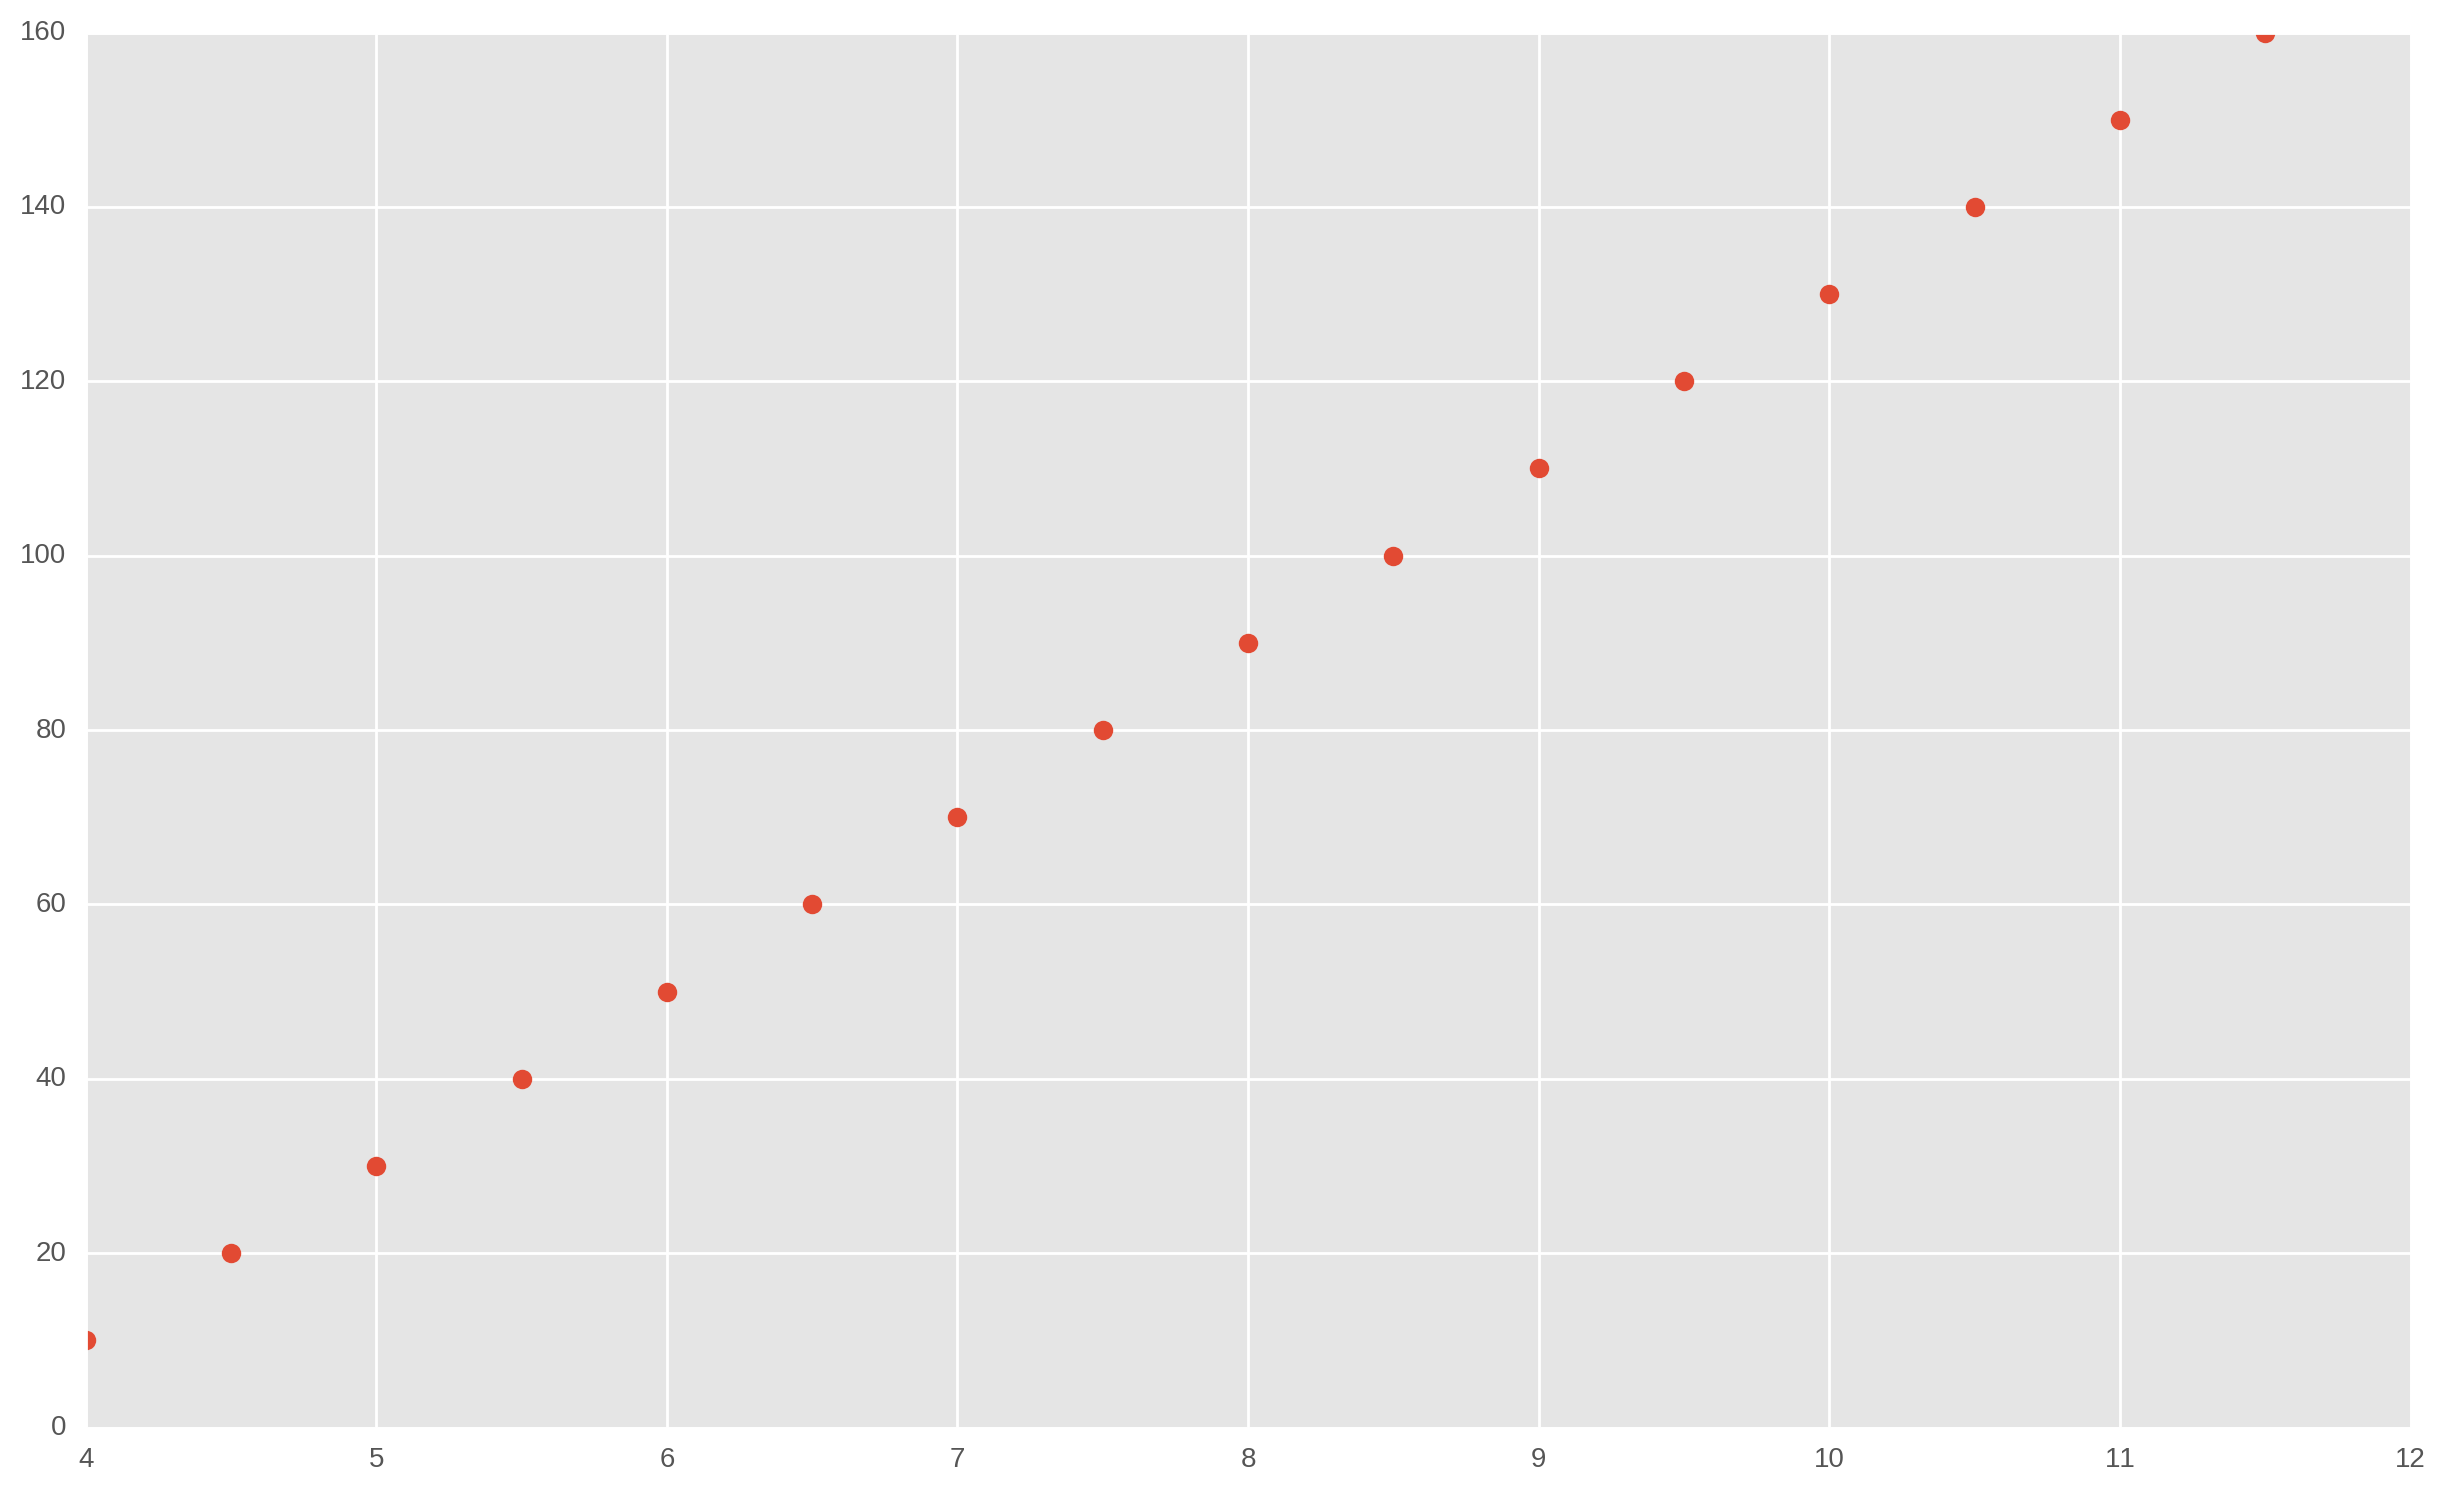

In [86]:

x = [4,5,6,7,8,9,10,11,12,13,14,15,0,1,2,3]
y = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(len(x)), y, 'o')
# ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x)
plt.show()

# play with spearman correlation and pearson correlation: 
# spearman deal with ranks 
# pearson deal with values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faad2b0b090>]], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faad2a4e950>]], dtype=object)

(0.0027026152960293141, 0.93197720859965028)

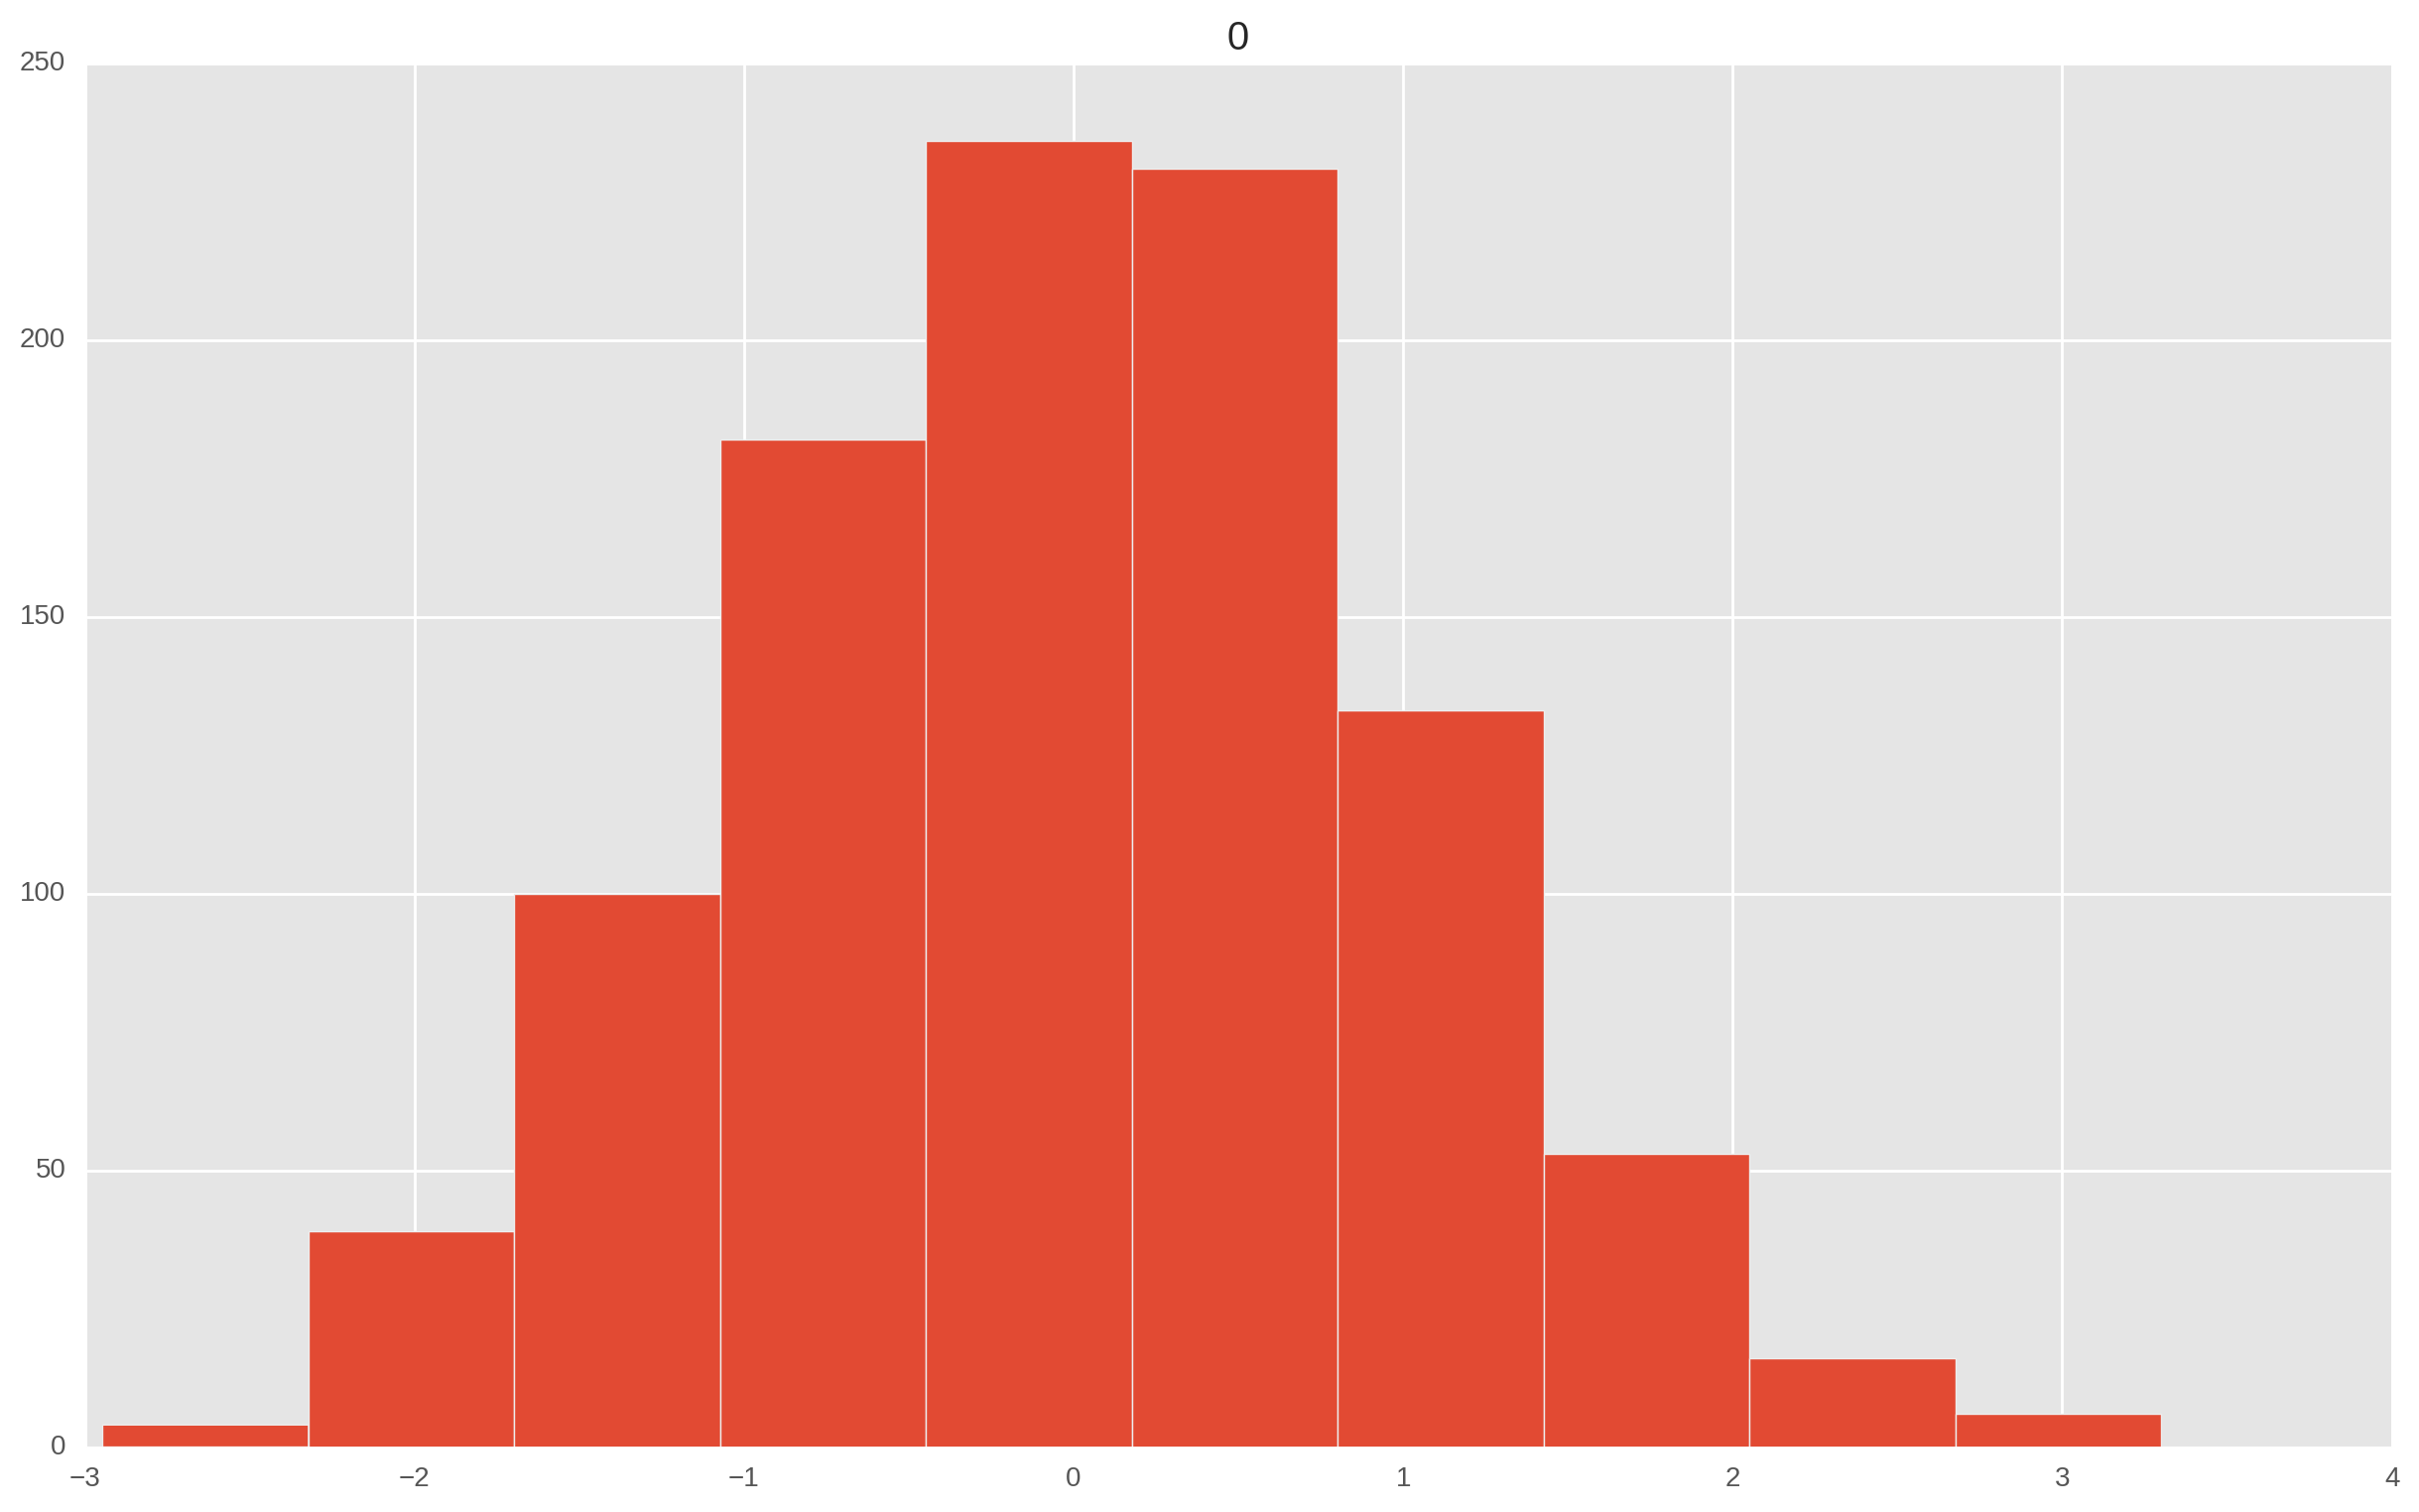

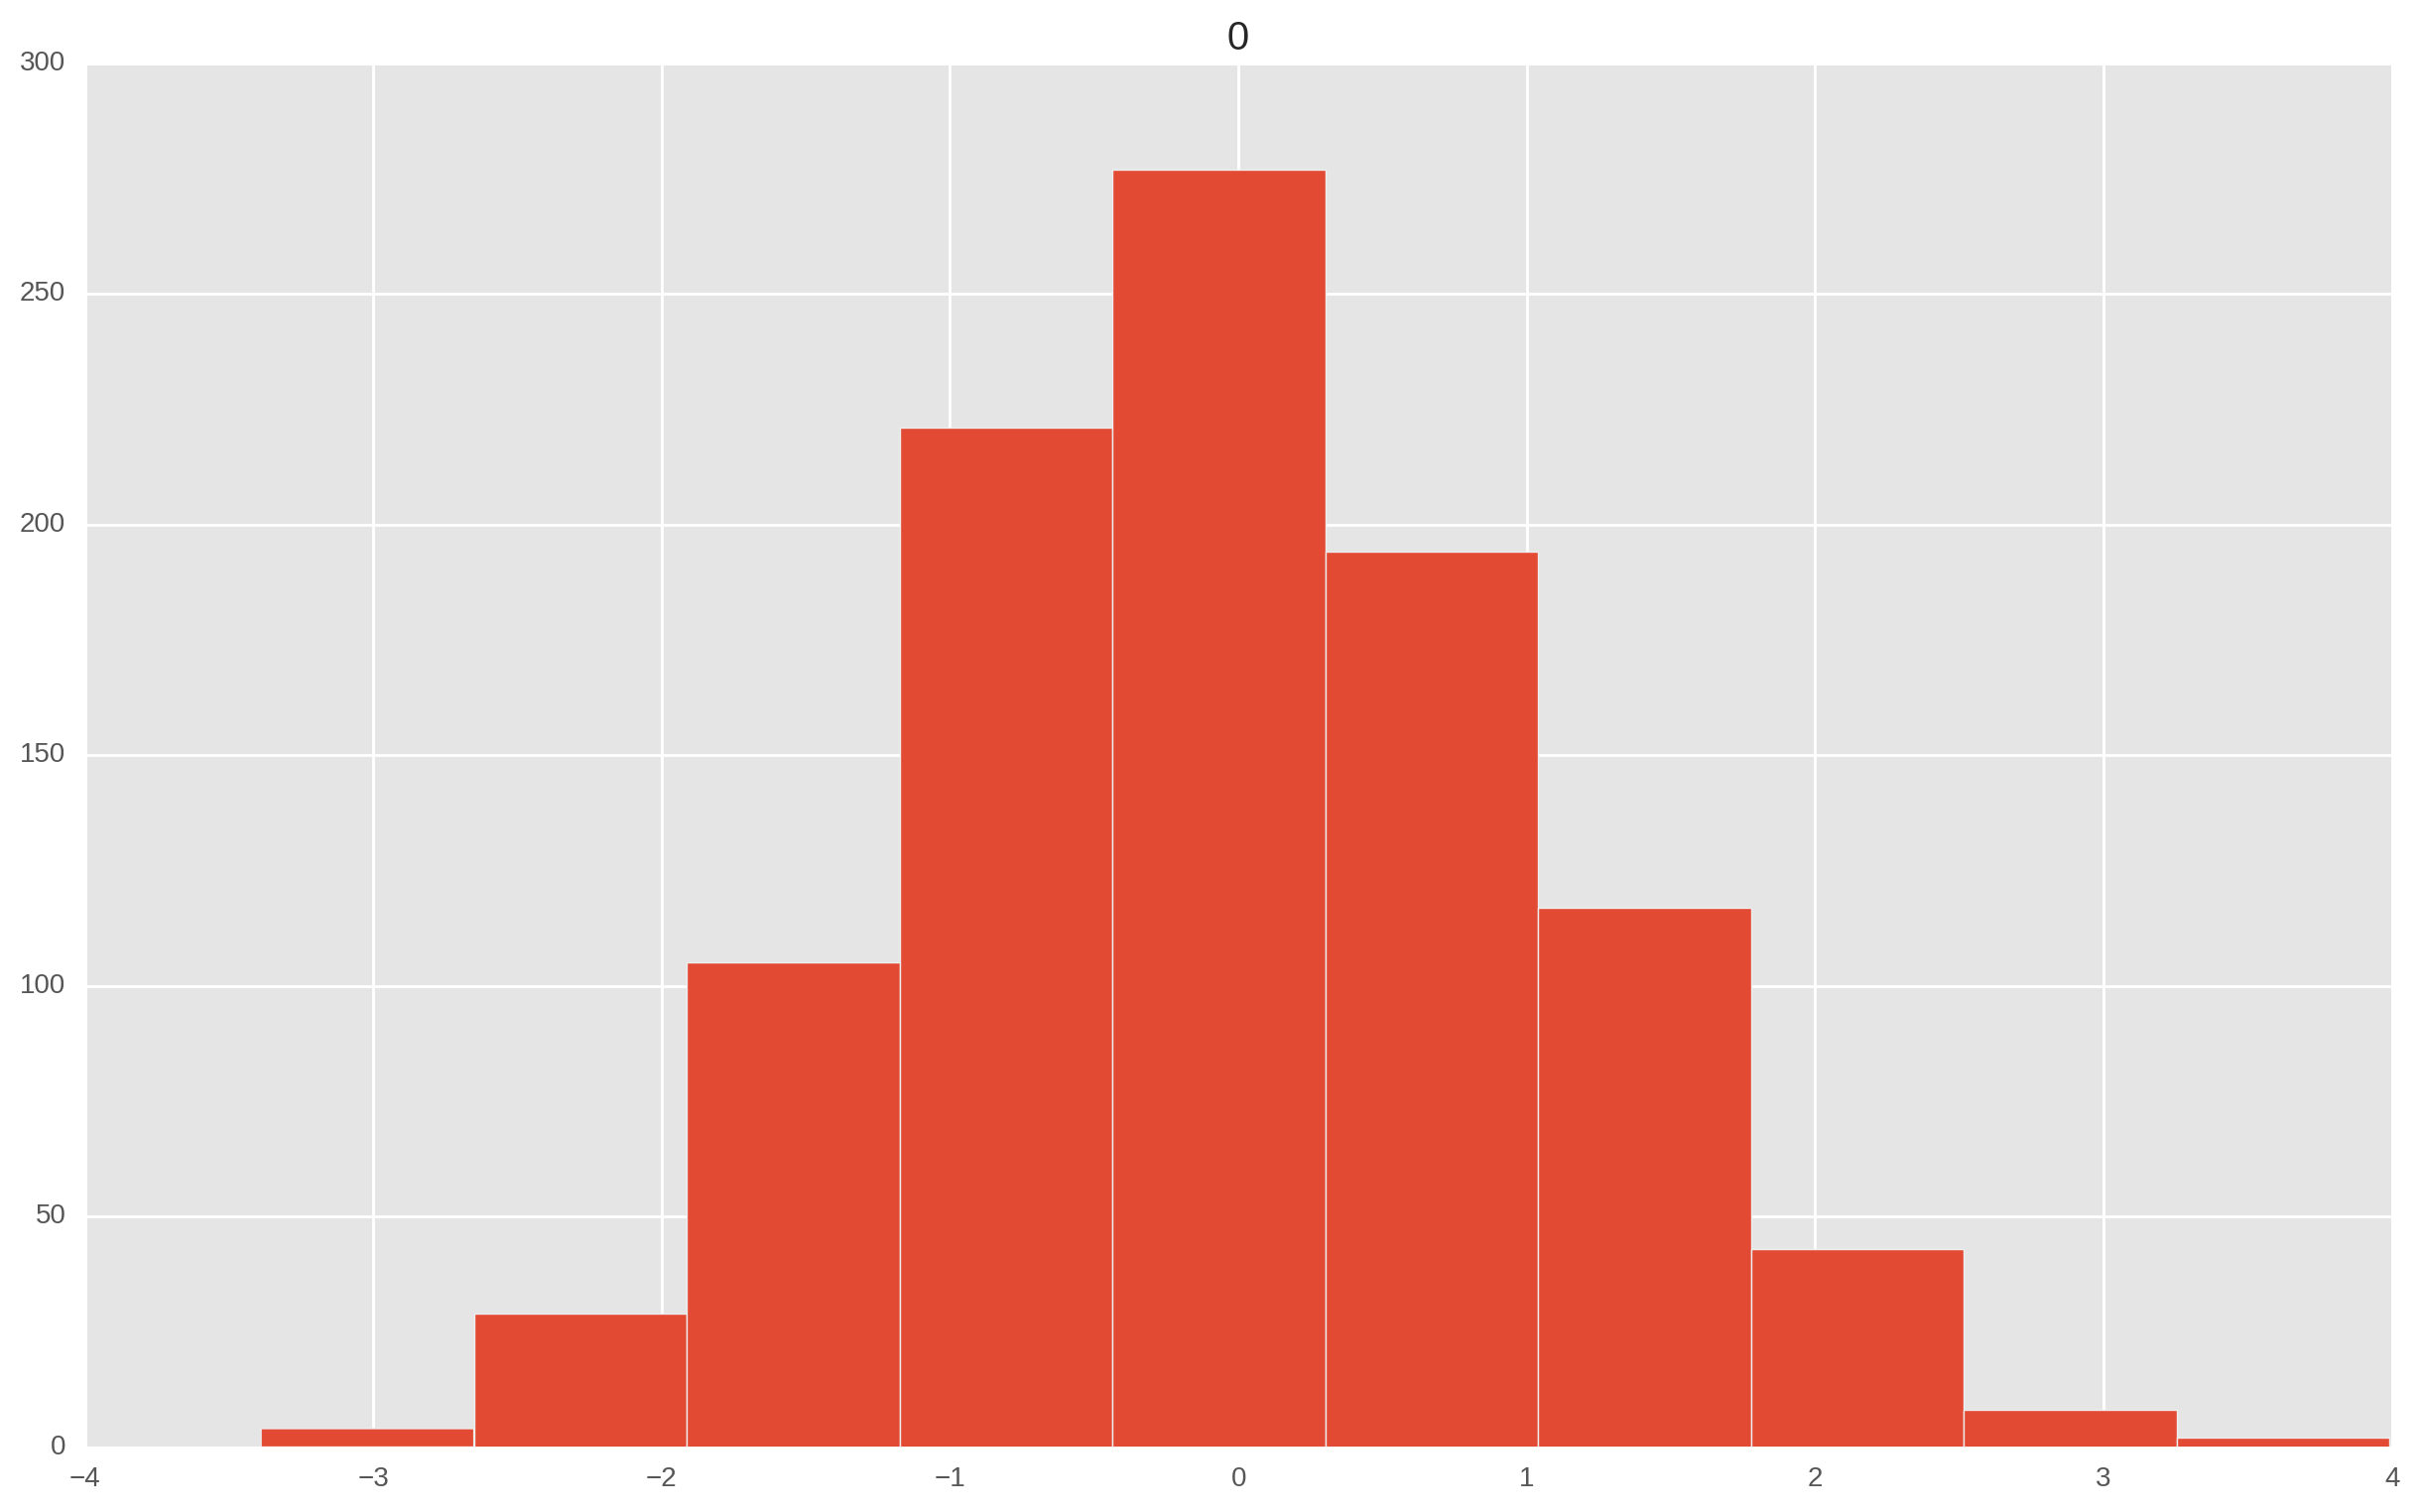

In [694]:
# this demonstrate that randomly generate paired values has no monotic correlation
# data are normally distributed, so it is valid to use pearson correlation analysis
x = np.random.randn(1000)
pd.DataFrame(x).hist()
y = np.random.randn(1000)
pd.DataFrame(y).hist()
ss.pearsonr(x, y)

In [695]:
x = [1,2,4,2,6,7]
y = [12,45, 88, 36, 1000, 4500]
ss.pearsonr(x, y)

(0.79667705839201897, 0.057807620451563353)

In [723]:
df = pd.DataFrame(ss.rankdata(x), ss.rankdata(y)).reset_index().sort_values('index').rename(columns={'index':'x', 0: 'y'})
df

,x,y
0,1.0,1.0
3,2.0,2.5
1,3.0,2.5
2,4.0,4.0
4,5.0,5.0
5,6.0,6.0


In [726]:
ss.spearmanr(df.x, df.y)

SpearmanrResult(correlation=0.98561076060916231, pvalue=0.00030908566784966989)

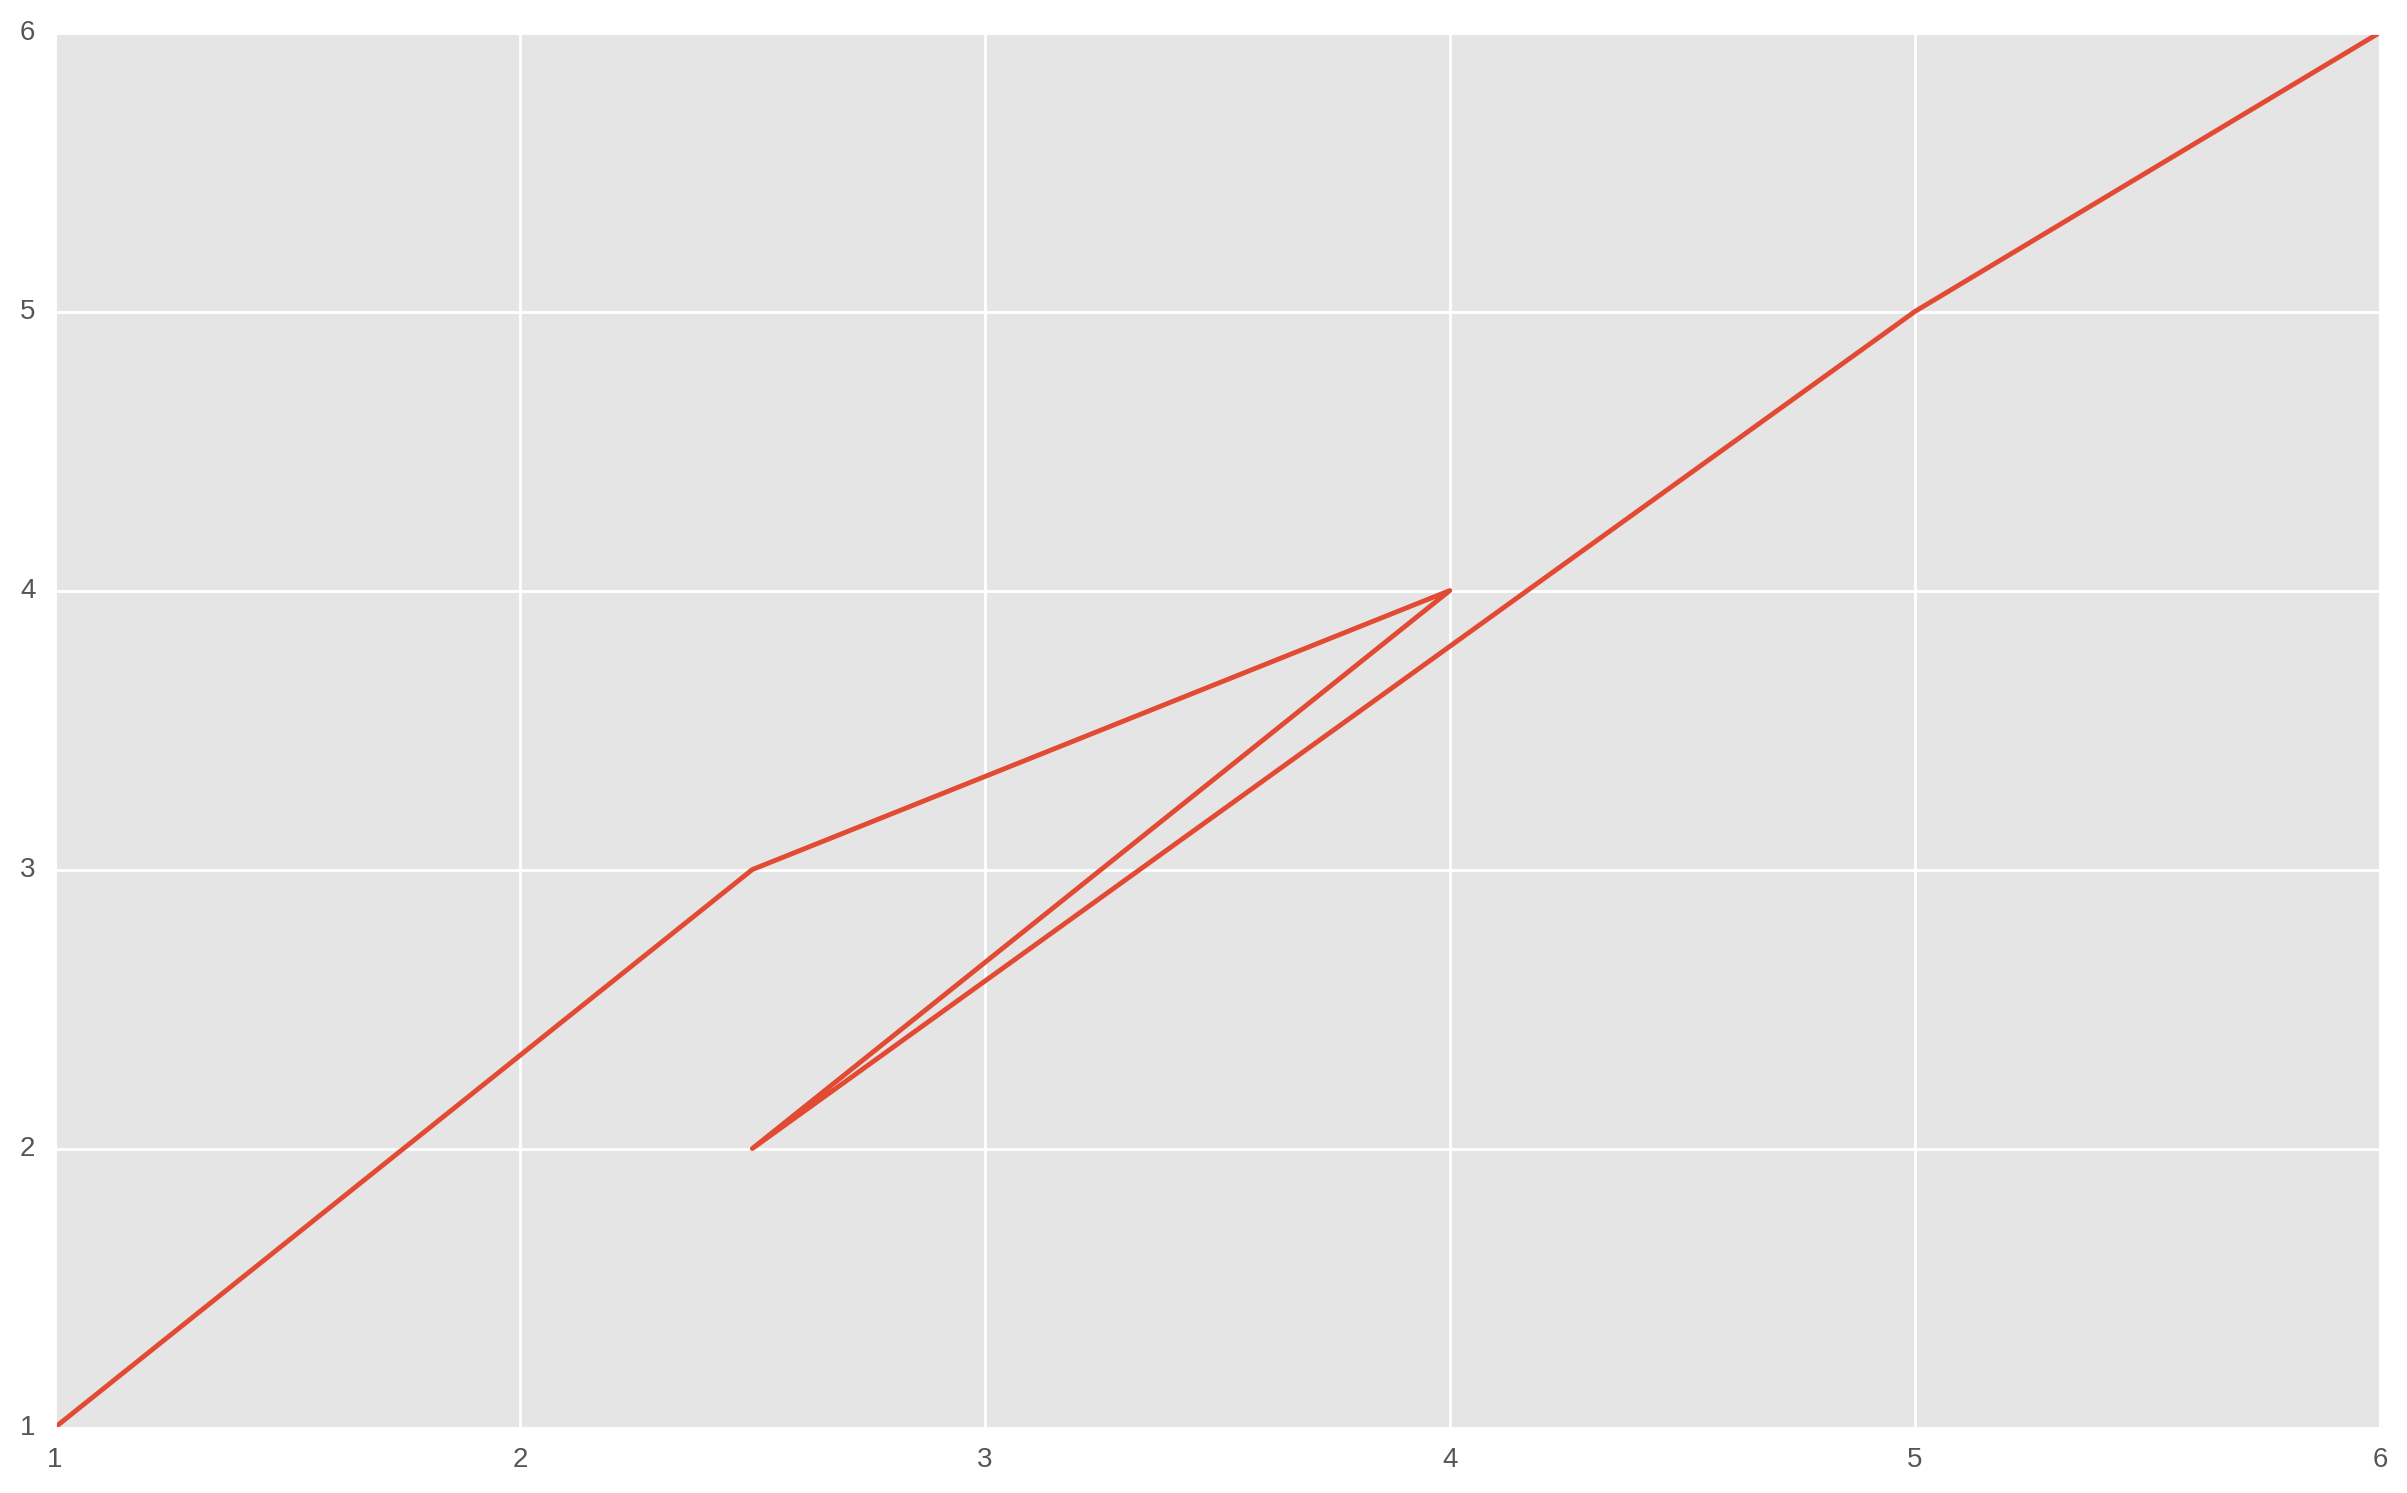

In [708]:
plt.plot(ss.rankdata(x), ss.rankdata(y))